In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['OPENBLAS_NUM_THREAD'] = '1'

In [2]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import typing as ty
from torch import Tensor
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [3]:
class ResNet(nn.Module):
    def __init__(
        self,
        *,
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        d_embedding: int,
        d: int,
        d_hidden_factor: float,
        n_layers: int,
        activation: str,
        normalization: str,
        hidden_dropout: float,
        residual_dropout: float,
        d_out: int,
    ) -> None:
        super().__init__()

        def make_normalization():
            return {'batchnorm': nn.BatchNorm1d, 'layernorm': nn.LayerNorm}[
                normalization
            ](d)

        self.main_activation = nn.ReLU()
        self.last_activation = nn.ReLU()
        self.residual_dropout = residual_dropout
        self.hidden_dropout = hidden_dropout

        d_in = d_numerical
        d_hidden = int(d * d_hidden_factor)

        self.first_layer = nn.Linear(d_in, d)
        self.layers = nn.ModuleList(
            [
                nn.ModuleDict(
                    {
                        'norm': make_normalization(),
                        'linear0': nn.Linear(
                            d, d_hidden * (2 if activation.endswith('glu') else 1)
                        ),
                        'linear1': nn.Linear(d_hidden, d),
                    }
                )
                for _ in range(n_layers)
            ]
        )
        self.last_normalization = make_normalization()
        self.head = nn.Linear(d, d_out)

    def forward(self, x_num: Tensor, x_cat: ty.Optional[Tensor]) -> Tensor:
        x = []
        if x_num is not None:
            x.append(x_num)
        if x_cat is not None:
            x.append(
                self.category_embeddings(x_cat + self.category_offsets[None]).view(
                    x_cat.size(0), -1
                )
            )
        x = torch.cat(x, dim=-1)

        x = self.first_layer(x)
        for layer in self.layers:
            layer = ty.cast(ty.Dict[str, nn.Module], layer)
            z = x
            z = layer['norm'](z)
            z = layer['linear0'](z)
            z = self.main_activation(z)
            if self.hidden_dropout:
                z = F.dropout(z, self.hidden_dropout, self.training)
            z = layer['linear1'](z)
            if self.residual_dropout:
                z = F.dropout(z, self.residual_dropout, self.training)
            x = x + z
        x = self.last_normalization(x)
        x = self.last_activation(x)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [4]:
def DataLoadAndScale(dataset_folder, normalizer='standard', regression=False, seed=777, noise=1e-3):
    X_train = np.load(f'data_tabular/{dataset_folder}/N_train.npy')
    y_train = np.load(f'data_tabular/{dataset_folder}/y_train.npy')
    X_test = np.load(f'data_tabular/{dataset_folder}/N_test.npy')
    y_test = np.load(f'data_tabular/{dataset_folder}/y_test.npy')
    X_val = np.load(f'data_tabular/{dataset_folder}/N_val.npy')
    y_val = np.load(f'data_tabular/{dataset_folder}/y_val.npy')

    m, s = y_train.mean(), y_train.std()
    if regression == True:
        y_train = (y_train - m) / s
        y_val = (y_val - m) / s
        y_test = (y_test - m) / s

    data_cb = {
        'X_train' : X_train,
        'X_val' : X_val,
        'X_test' : X_test,
        'y_train' : y_train,
        'y_val' : y_val,
        'y_test' : y_test,
        'mean' : m,
        'std' : s
    }
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    data_model = {}
    if normalizer == 'standard':
        scaler = StandardScaler()
        data_model['X_train'] = torch.from_numpy(scaler.fit_transform(X_train))
        data_model['X_test'] = torch.from_numpy(scaler.transform(X_test))
        data_model['X_val'] = torch.from_numpy(scaler.transform(X_val))
    else:
        quantile_transformer_params = {
            'output_distribution' : 'normal',
            'n_quantiles' : max(min(X_train.shape[0] // 30, 100), 10), # можно поменять здесь
            'subsample' : int(1e9)
        }
        stds = np.std(X_train, axis=0, keepdims=True)
        noise_std = noise / np.maximum(stds, noise)  # type: ignore[code]
        X_train_new = X_train + noise_std * np.random.default_rng(seed).standard_normal(  # type: ignore[code]
                X_train.shape
        ).astype('float32')
        transformer = QuantileTransformer(**quantile_transformer_params)
        data_model['X_train'] = torch.from_numpy(transformer.fit_transform(X_train_new))
        data_model['X_test'] = torch.from_numpy(transformer.transform(X_test))
        data_model['X_val'] = torch.from_numpy(transformer.transform(X_val))

    data_model['y_train'] = torch.from_numpy(y_train)
    data_model['y_test'] = torch.from_numpy(y_test)
    data_model['y_val']= torch.from_numpy(y_val)
    data_model['mean'] = m
    data_model['std'] = s
    
    return data_model, data_cb

In [5]:
def model_num_params(model):
    sum_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        print('{: <19} ~  {: <7} params'.format(param[0], num_params))
        sum_params += num_params
    print(f'\nIn total: {sum_params} params')
    return sum_params

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def create_model_and_optimizer(model_class, model_params, optimizer_params, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_params)
    return model, optimizer

cuda


In [7]:
def get_results(model, criterion, X_train, y_train, X_val, y_val, X_test, y_test, metric, regression=False):
    model.eval()
    X_train_dev = X_train.to(device)
    X_val_dev = X_val.to(device)
    X_test_dev = X_test.to(device)
    y_val_dev = y_val.to(device)
    y_test_dev = y_test.to(device)
    with torch.no_grad():
        preds_val = model(X_val_dev, None)
        preds_test = model(X_test_dev, None)
        preds_train = model(X_train_dev, None)
        val_loss = criterion(preds_val, y_val_dev)
        test_loss = criterion(preds_test, y_test_dev)
        
        if regression == False:
            preds_train = torch.argmax(torch.softmax(preds_train, dim=-1), dim=-1)
            preds_val = torch.argmax(torch.softmax(preds_val, dim=-1), dim=-1)
            preds_test = torch.argmax(torch.softmax(preds_test, dim=-1), dim=-1)
        
        preds_train = preds_train.detach().cpu().numpy()
        preds_val = preds_val.detach().cpu().numpy()
        preds_test = preds_test.detach().cpu().numpy()

        return metric(y_val, preds_val), val_loss, metric(y_test, preds_test), test_loss, metric(y_train, preds_train)

In [8]:
def train_loop(model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test, mean, std,
               criterion, num_epochs, batch_size, eval_batch_size, patience, metric, model_num=None, regression=False):
    epoch_val_accuracy = []
    epoch_test_accuracy = []
    epoch_train_accuracy = []
    train_losses = []
    val_losses = []
    test_losses = []
    num_batches = (X_train.shape[0] + batch_size - 1) // batch_size
    max_val_accuracy = -10 if regression == False else 1e9
    for epoch_index in trange(num_epochs):
        model.train(True)
        epoch_average_loss = 0.0
        for batch_index in range(num_batches):
            batch_X = X_train[batch_index * batch_size : min((batch_index + 1) * batch_size, X_train.shape[0])].to(device)
            batch_y = y_train[batch_index * batch_size : min((batch_index + 1) * batch_size, X_train.shape[0])].to(device)
            preds = model(batch_X, None)
    
            loss = criterion(preds, batch_y)
            if batch_index < num_batches - 1:
                epoch_average_loss += loss.item()
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_losses.append(epoch_average_loss / (num_batches - 1))    
        val_accuracy, val_loss, test_accuracy, test_loss, train_accuracy = get_results(model,criterion, X_train, y_train,
                                                                                       X_val, y_val, X_test, y_test, metric, regression=regression)
            
        epoch_val_accuracy.append(val_accuracy)
        if val_accuracy > max_val_accuracy and regression == False:
            torch.save(model.state_dict(), 'resnet.pt')
            max_val_accuracy = val_accuracy
        elif val_accuracy < max_val_accuracy and regression == True:
            torch.save(model.state_dict(), 'resnet.pt')
            max_val_accuracy = val_accuracy
            
        epoch_test_accuracy.append(test_accuracy)
        epoch_train_accuracy.append(train_accuracy)
        val_losses.append(val_loss.item())
        test_losses.append(test_loss.item())
        
                
        clear_output(True)
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        fig.suptitle(f'#{epoch_index}/{num_epochs}:')
        plt.subplot(121)
        plt.title('loss' if model_num == None else f"loss_model{model_num}")
        plt.plot(train_losses, 'r.-', label='train')
        plt.plot(val_losses, 'g.-', label='val')
        plt.plot(test_losses, 'y.-', label='test')
        plt.legend()
        plt.grid()
        plt.subplot(122)
        plt.title('accuracy' if model_num == None else f"accuracy_model{model_num}")
        plt.plot(epoch_train_accuracy, 'r.-', label='train')
        plt.plot(epoch_val_accuracy, 'g.-', label='val')
        plt.plot(epoch_test_accuracy, 'y.-', label='test')
        plt.legend()
        plt.grid()
        plt.show()        
    return epoch_test_accuracy, val_losses

In [9]:
def LearnNModels(N, model_name, model_params, optimizer_params, data, train_params, metric, regression=False):
    models = []
    y_train_labels = []
    y_val_labels = []
    y_test_labels = []
    accuracy = []
    for i in range(N):
        model, opt = create_model_and_optimizer(model_name, model_params, optimizer_params)
        epoch_test_accuracy, val_losses = train_loop(model, opt, **data, **train_params, metric=metric, model_num = i + 1, regression=regression)
        model.load_state_dict(torch.load('resnet.pt'))
        model.eval()
        with torch.no_grad():
            train_labels = model(data['X_train'].to(device), None)
            val_labels = model(data['X_val'].to(device), None)
            test_labels = model(data['X_test'].to(device), None)
            if regression == False:
                test_labels = torch.argmax(torch.softmax(test_labels, dim=-1), dim=-1)
                train_labels = torch.argmax(torch.softmax(train_labels, dim=-1), dim=-1)
                val_labels = torch.argmax(torch.softmax(val_labels, dim=-1), dim=-1)
                
            y_train_labels.append(train_labels)
            y_val_labels.append(val_labels)
            y_test_labels.append(test_labels)
            acc = metric(data['y_test'], test_labels.detach().cpu().numpy())

            accuracy.append(acc)
        model = model.cpu()    
        models.append(model)
    return {'train_labels' : y_train_labels,
            'val_labels' : y_val_labels,
            'test_labels' : y_test_labels,
            'accuracy' : accuracy,
            'models' : models} 

In [10]:
def CatBoostNLearning(teacher_training, cb_type, catboost_params, data_cb, metric, N=5, regression=False):
    accuracy = {}
    cb = cb_type(**catboost_params)
    cb.fit(data_cb['X_train'], data_cb['y_train'], eval_set=(data_cb['X_val'], data_cb['y_val']))
    preds = cb.predict(data_cb['X_test'])
    accuracy['original'] = metric(data_cb['y_test'], preds)
    
    for i in trange(len(teacher_training['models'][:N])):
        cb = cb_type(**catboost_params)
        train_teacher_labels = teacher_training['train_labels'][i].detach().cpu().numpy()
        val_teacher_labels = teacher_training['val_labels'][i].detach().cpu().numpy()
        test_teacher_labels = teacher_training['test_labels'][i].detach().cpu().numpy()
        cb.fit(data_cb['X_train'], train_teacher_labels, eval_set=(data_cb['X_val'], val_teacher_labels))
        predicts = cb.predict(data_cb['X_test'])
        accuracy[f'distill_{i + 1}'] = metric(data_cb['y_test'], predicts)
    
    agg_func = torch.mode if regression == False else torch.mean
    train_labels1 = agg_func(torch.stack(teacher_training['train_labels'][:5], dim=-1), dim=-1)
    train_labels2 = agg_func(torch.stack(teacher_training['train_labels'][5:10], dim=-1), dim=-1)
    train_labels3 = agg_func(torch.stack(teacher_training['train_labels'][10:15], dim=-1), dim=-1)
    
    val_labels1 = agg_func(torch.stack(teacher_training['val_labels'][:5], dim=-1), dim=-1)
    val_labels2 = agg_func(torch.stack(teacher_training['val_labels'][5:10], dim=-1), dim=-1)
    val_labels3 = agg_func(torch.stack(teacher_training['val_labels'][10:15], dim=-1), dim=-1)

    if regression == False:
        train_labels1 = train_labels1.values
        train_labels2 = train_labels2.values
        train_labels3 = train_labels3.values
        
        val_labels1 = val_labels1.values
        val_labels2 = val_labels2.values
        val_labels3 = val_labels3.values

    accuracy_ensemble = []

    cb = cb_type(**catboost_params)
    cb.fit(data_cb['X_train'], train_labels1.detach().cpu().numpy(), eval_set=(data_cb['X_val'], val_labels1.detach().cpu().numpy()))
    preds = cb.predict(data_cb['X_test'])
    accuracy_ensemble.append(metric(data_cb['y_test'], preds))

    cb = cb_type(**catboost_params)
    cb.fit(data_cb['X_train'], train_labels2.detach().cpu().numpy(), eval_set=(data_cb['X_val'], val_labels2.detach().cpu().numpy()))
    preds = cb.predict(data_cb['X_test'])
    accuracy_ensemble.append(metric(data_cb['y_test'], preds))

    cb = cb_type(**catboost_params)
    cb.fit(data_cb['X_train'], train_labels3.detach().cpu().numpy(), eval_set=(data_cb['X_val'], val_labels3.detach().cpu().numpy()))
    preds = cb.predict(data_cb['X_test'])
    accuracy_ensemble.append(metric(data_cb['y_test'], preds))
    return {'accuracy' : accuracy, 'accuracy_ensemble' : accuracy_ensemble}

Helena dataset

In [207]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 8192,
    'num_epochs' : 110,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

resnet_params = {
    'd_numerical' : 27,
    'activation' : 'relu',
    'd' : 431,
    'd_embedding' : None,
    'categories' : None,
    'd_hidden_factor' : 3.782741476775878,
    'hidden_dropout' : 0.457601679367841,
    'n_layers' : 7,
    'normalization' : 'batchnorm',
    'residual_dropout' : 0.0,
    'd_out' : 100
}

optimizer_params = {
    'lr' : 3.078620509197834e-05,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.6788373487088936,
    'depth' : 5,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 3.066893023126909,
    'leaf_estimation_iterations' : 10,
    'learning_rate' : 0.04324396670696182,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

In [19]:
def PrintResults(results_models_learning, results_cb_learning, regression=False, std = None):
    for i in range(len(results_cb_learning['accuracy']) - 1):
        model_metric = results_models_learning['accuracy'][i]
        cb_original_metric = results_cb_learning['accuracy']['original']
        cb_metric = results_cb_learning['accuracy'][f'distill_{i + 1}']
        if regression == True:
            model_metric = model_metric**(0.5) * std
            cb_original_metric = cb_original_metric**(0.5) * std
            cb_metric = cb_metric**(0.5) * std
        print(f'model_{i}_metric : {model_metric}')
        print(f'distill_{i} : {cb_original_metric} ---------> {cb_metric}')
    average = 0.0
    for i in range(len(results_cb_learning['accuracy_ensemble'])):
        a = results_cb_learning['accuracy_ensemble'][i]
        if regression == True:
            a = a**(0.5) * std
        average += a 
    print('averaged ensembles accuracy : ', average / len(results_cb_learning['accuracy_ensemble']))    

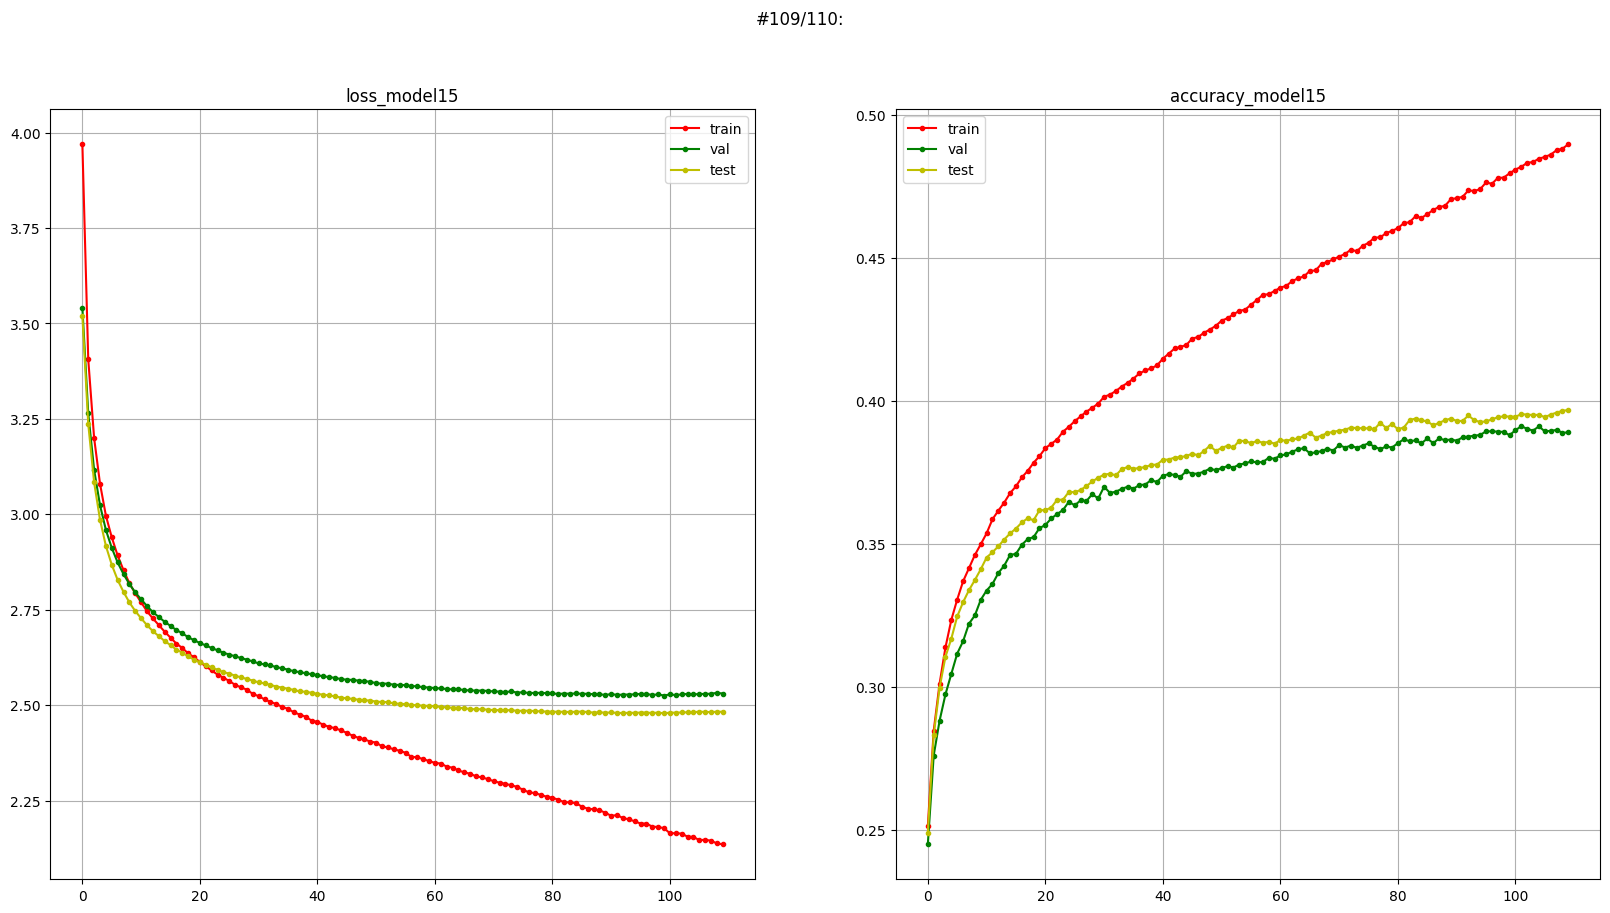

100%|█████████████████████████████████████████| 110/110 [03:32<00:00,  1.93s/it]


0:	learn: 0.1719154	test: 0.1664110	best: 0.1664110 (0)	total: 137ms	remaining: 4m 33s
10:	learn: 0.2085850	test: 0.2016871	best: 0.2017830 (7)	total: 1.65s	remaining: 4m 59s
20:	learn: 0.2452545	test: 0.2358129	best: 0.2358129 (20)	total: 4.47s	remaining: 7m 1s
30:	learn: 0.2609529	test: 0.2488497	best: 0.2488497 (30)	total: 7.36s	remaining: 7m 47s
40:	learn: 0.2727447	test: 0.2618865	best: 0.2618865 (40)	total: 10.4s	remaining: 8m 15s
50:	learn: 0.2842249	test: 0.2707055	best: 0.2707055 (50)	total: 13.4s	remaining: 8m 33s
60:	learn: 0.2952737	test: 0.2781825	best: 0.2781825 (60)	total: 16.6s	remaining: 8m 46s
70:	learn: 0.3039018	test: 0.2829755	best: 0.2829755 (70)	total: 19.7s	remaining: 8m 55s
80:	learn: 0.3126019	test: 0.2926572	best: 0.2926572 (80)	total: 22.9s	remaining: 9m 1s
90:	learn: 0.3221647	test: 0.2996549	best: 0.2996549 (90)	total: 26s	remaining: 9m 5s
100:	learn: 0.3297383	test: 0.3031058	best: 0.3031058 (100)	total: 29.2s	remaining: 9m 8s
110:	learn: 0.3369763	test: 

  0%|                                                    | 0/15 [00:00<?, ?it/s]

0:	learn: 0.2140015	test: 0.2096434	best: 0.2096434 (0)	total: 99.4ms	remaining: 3m 18s
10:	learn: 0.3312482	test: 0.3319594	best: 0.3319594 (10)	total: 1.09s	remaining: 3m 16s
20:	learn: 0.3488160	test: 0.3494057	best: 0.3494057 (20)	total: 2.2s	remaining: 3m 27s
30:	learn: 0.3752037	test: 0.3726994	best: 0.3726994 (30)	total: 4.11s	remaining: 4m 21s
40:	learn: 0.4214840	test: 0.4144939	best: 0.4144939 (40)	total: 7.07s	remaining: 5m 37s
50:	learn: 0.4515866	test: 0.4371166	best: 0.4371166 (50)	total: 10.1s	remaining: 6m 25s
60:	learn: 0.4778545	test: 0.4622316	best: 0.4622316 (60)	total: 13.1s	remaining: 6m 57s
70:	learn: 0.5000719	test: 0.4817868	best: 0.4817868 (70)	total: 16.1s	remaining: 7m 18s
80:	learn: 0.5200844	test: 0.4981787	best: 0.4981787 (80)	total: 19.2s	remaining: 7m 34s
90:	learn: 0.5385150	test: 0.5131327	best: 0.5131327 (90)	total: 22.2s	remaining: 7m 45s
100:	learn: 0.5542374	test: 0.5266488	best: 0.5266488 (100)	total: 25.2s	remaining: 7m 53s
110:	learn: 0.5703192

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [63]:
dataset_folder = 'helena'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder)
results_models_learning = LearnNModels(15, ResNet, resnet_params, optimizer_params, data_model, train_params, metric)
results_cb_learning = CatBoostNLearning(results_models_learning, catboost_params, data_cb, metric)

In [64]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.39616564417177913
distill_0 : 0.3821319018404908 ---------> 0.3832055214723926
model_1_metric : 0.39562883435582824
distill_1 : 0.3821319018404908 ---------> 0.3820552147239264
model_2_metric : 0.3957822085889571
distill_2 : 0.3821319018404908 ---------> 0.3834355828220859
model_3_metric : 0.3959355828220859
distill_3 : 0.3821319018404908 ---------> 0.3825920245398773
model_4_metric : 0.39470858895705524
distill_4 : 0.3821319018404908 ---------> 0.3822852760736196
model_5_metric : 0.3937116564417178
distill_5 : 0.3821319018404908 ---------> 0.3851993865030675
model_6_metric : 0.3929447852760736
distill_6 : 0.3821319018404908 ---------> 0.38243865030674845
model_7_metric : 0.39363496932515335
distill_7 : 0.3821319018404908 ---------> 0.3839723926380368
model_8_metric : 0.3944018404907976
distill_8 : 0.3821319018404908 ---------> 0.3836656441717791
model_9_metric : 0.39631901840490796
distill_9 : 0.3821319018404908 ---------> 0.3834355828220859
model_10_metric : 0.3951

In [71]:
1.152607 / 3

0.3842023333333333

In [65]:
torch.cuda.empty_cache()
gc.collect()

101914

In [133]:
# Jannis Parameters
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 8192,
    'num_epochs' : 70,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

resnet_params = {
    'd_numerical' : 54,
    'activation' : 'relu',
    'd' : 204,
    'd_embedding' : None,
    'categories' : None,
    'd_hidden_factor' : 1.176347541077555,
    'hidden_dropout' : 0.4540591352225014,
    'n_layers' : 7,
    'normalization' : 'batchnorm',
    'residual_dropout' : 0.0,
    'd_out' : 4
}

optimizer_params = {
    'lr' : 0.008531624023162135,
    'weight_decay' : 1.573734752532542e-06
}

catboost_params = {
    'bagging_temperature' : 0.1775789113135668,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.333715101902845,
    'leaf_estimation_iterations' : 3,
    'learning_rate' : 0.04816591530865447,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 1,
    'eval_metric': 'Accuracy'
}

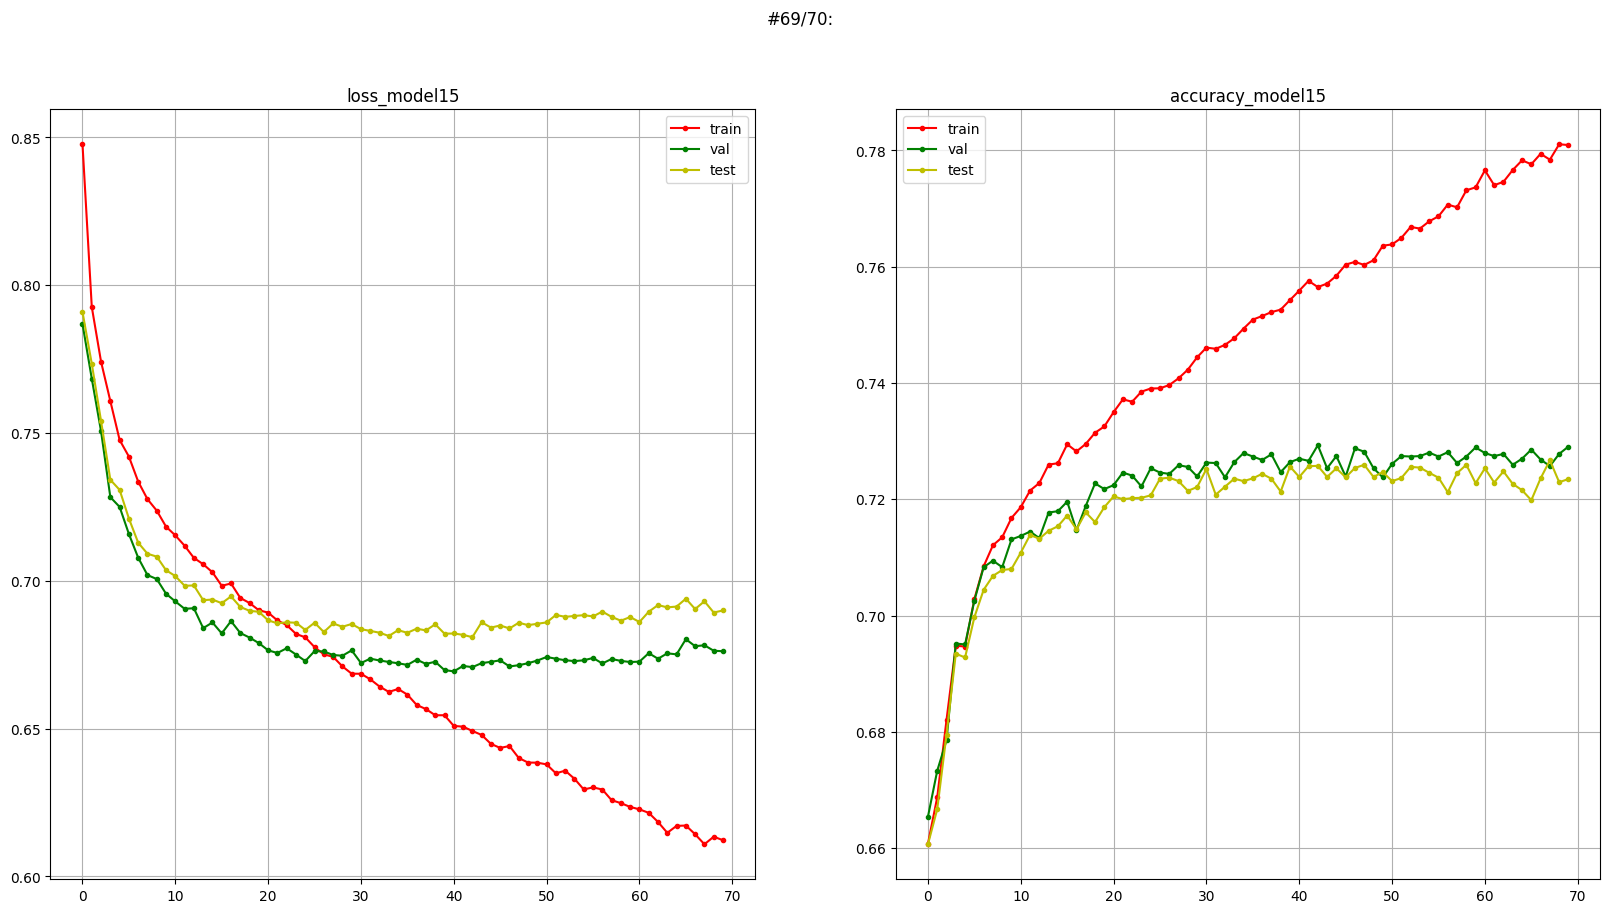

100%|███████████████████████████████████████████| 70/70 [02:24<00:00,  2.07s/it]


0:	learn: 0.6486900	test: 0.6508434	best: 0.6508434 (0)	total: 45.8ms	remaining: 1m 31s
10:	learn: 0.6827461	test: 0.6736080	best: 0.6736080 (10)	total: 474ms	remaining: 1m 25s
20:	learn: 0.6927484	test: 0.6798776	best: 0.6798776 (20)	total: 875ms	remaining: 1m 22s
30:	learn: 0.7013510	test: 0.6871921	best: 0.6871921 (30)	total: 1.28s	remaining: 1m 21s
40:	learn: 0.7084608	test: 0.6911479	best: 0.6911479 (40)	total: 1.68s	remaining: 1m 20s
50:	learn: 0.7163731	test: 0.6959248	best: 0.6959248 (50)	total: 2.08s	remaining: 1m 19s
60:	learn: 0.7227364	test: 0.6987610	best: 0.6988356 (55)	total: 2.49s	remaining: 1m 19s
70:	learn: 0.7289878	test: 0.7035378	best: 0.7036125 (69)	total: 2.86s	remaining: 1m 17s
80:	learn: 0.7332239	test: 0.7068966	best: 0.7068966 (80)	total: 3.24s	remaining: 1m 16s
90:	learn: 0.7373666	test: 0.7089118	best: 0.7089118 (89)	total: 3.62s	remaining: 1m 15s
100:	learn: 0.7411174	test: 0.7104045	best: 0.7115987 (97)	total: 3.99s	remaining: 1m 14s
110:	learn: 0.7444764

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7636411	test: 0.7669801	best: 0.7669801 (0)	total: 36.1ms	remaining: 1m 12s
10:	learn: 0.8031276	test: 0.7987013	best: 0.7987013 (10)	total: 390ms	remaining: 1m 10s
20:	learn: 0.8188400	test: 0.8124347	best: 0.8124347 (20)	total: 752ms	remaining: 1m 10s
30:	learn: 0.8304285	test: 0.8206449	best: 0.8206449 (30)	total: 1.1s	remaining: 1m 10s
40:	learn: 0.8408972	test: 0.8314674	best: 0.8314674 (40)	total: 1.46s	remaining: 1m 9s
50:	learn: 0.8506195	test: 0.8400508	best: 0.8400508 (50)	total: 1.8s	remaining: 1m 8s
60:	learn: 0.8574308	test: 0.8457232	best: 0.8457232 (60)	total: 2.14s	remaining: 1m 8s
70:	learn: 0.8645592	test: 0.8507240	best: 0.8507240 (70)	total: 2.48s	remaining: 1m 7s
80:	learn: 0.8695977	test: 0.8552769	best: 0.8552769 (80)	total: 2.82s	remaining: 1m 6s
90:	learn: 0.8756065	test: 0.8592327	best: 0.8592327 (90)	total: 3.16s	remaining: 1m 6s
100:	learn: 0.8802904	test: 0.8622929	best: 0.8623675 (99)	total: 3.5s	remaining: 1m 5s
110:	learn: 0.8847130	test: 0.8

 20%|█████████                                    | 1/5 [01:12<04:51, 72.78s/it]

0:	learn: 0.7671680	test: 0.7648156	best: 0.7648156 (0)	total: 36ms	remaining: 1m 11s
10:	learn: 0.8110025	test: 0.8022839	best: 0.8022839 (9)	total: 393ms	remaining: 1m 11s
20:	learn: 0.8258379	test: 0.8164651	best: 0.8164651 (20)	total: 756ms	remaining: 1m 11s
30:	learn: 0.8378368	test: 0.8267652	best: 0.8267652 (30)	total: 1.11s	remaining: 1m 10s
40:	learn: 0.8482869	test: 0.8351246	best: 0.8351246 (39)	total: 1.46s	remaining: 1m 9s
50:	learn: 0.8586064	test: 0.8443798	best: 0.8443798 (50)	total: 1.81s	remaining: 1m 9s
60:	learn: 0.8669665	test: 0.8507986	best: 0.8507986 (60)	total: 2.16s	remaining: 1m 8s
70:	learn: 0.8737217	test: 0.8567697	best: 0.8573668 (69)	total: 2.49s	remaining: 1m 7s
80:	learn: 0.8787042	test: 0.8605016	best: 0.8605016 (80)	total: 2.83s	remaining: 1m 7s
90:	learn: 0.8827723	test: 0.8634871	best: 0.8634871 (90)	total: 3.16s	remaining: 1m 6s
100:	learn: 0.8874002	test: 0.8669204	best: 0.8669204 (100)	total: 3.48s	remaining: 1m 5s
110:	learn: 0.8917855	test: 0.

 40%|██████████████████                           | 2/5 [02:25<03:38, 72.83s/it]

0:	learn: 0.7619990	test: 0.7640693	best: 0.7640693 (0)	total: 36.9ms	remaining: 1m 13s
10:	learn: 0.8061133	test: 0.8025825	best: 0.8025825 (10)	total: 393ms	remaining: 1m 10s
20:	learn: 0.8221430	test: 0.8160173	best: 0.8160173 (20)	total: 757ms	remaining: 1m 11s
30:	learn: 0.8333209	test: 0.8244514	best: 0.8244514 (30)	total: 1.11s	remaining: 1m 10s
40:	learn: 0.8431552	test: 0.8327362	best: 0.8327362 (40)	total: 1.47s	remaining: 1m 10s
50:	learn: 0.8510114	test: 0.8396776	best: 0.8397522 (49)	total: 1.87s	remaining: 1m 11s
60:	learn: 0.8592409	test: 0.8469921	best: 0.8469921 (60)	total: 2.27s	remaining: 1m 12s
70:	learn: 0.8656042	test: 0.8513957	best: 0.8513957 (70)	total: 2.66s	remaining: 1m 12s
80:	learn: 0.8711279	test: 0.8563218	best: 0.8564711 (79)	total: 3.06s	remaining: 1m 12s
90:	learn: 0.8768381	test: 0.8597552	best: 0.8597552 (90)	total: 3.46s	remaining: 1m 12s
100:	learn: 0.8817086	test: 0.8627407	best: 0.8627407 (100)	total: 3.84s	remaining: 1m 12s
110:	learn: 0.885776

 60%|███████████████████████████                  | 3/5 [03:38<02:25, 72.91s/it]

0:	learn: 0.7709562	test: 0.7760113	best: 0.7760113 (0)	total: 37.2ms	remaining: 1m 14s
10:	learn: 0.8133724	test: 0.8140021	best: 0.8140021 (10)	total: 394ms	remaining: 1m 11s
20:	learn: 0.8303725	test: 0.8253471	best: 0.8253471 (20)	total: 759ms	remaining: 1m 11s
30:	learn: 0.8422035	test: 0.8343783	best: 0.8343783 (30)	total: 1.12s	remaining: 1m 10s
40:	learn: 0.8550235	test: 0.8436334	best: 0.8436334 (40)	total: 1.47s	remaining: 1m 10s
50:	learn: 0.8622453	test: 0.8499030	best: 0.8499030 (50)	total: 1.82s	remaining: 1m 9s
60:	learn: 0.8709226	test: 0.8561726	best: 0.8564711 (59)	total: 2.16s	remaining: 1m 8s
70:	learn: 0.8764462	test: 0.8624422	best: 0.8624422 (70)	total: 2.5s	remaining: 1m 8s
80:	learn: 0.8826043	test: 0.8668458	best: 0.8668458 (80)	total: 2.85s	remaining: 1m 7s
90:	learn: 0.8874935	test: 0.8699806	best: 0.8702045 (87)	total: 3.19s	remaining: 1m 6s
100:	learn: 0.8920840	test: 0.8722944	best: 0.8725929 (99)	total: 3.54s	remaining: 1m 6s
110:	learn: 0.8968986	test: 

 80%|████████████████████████████████████         | 4/5 [04:51<01:12, 72.94s/it]

0:	learn: 0.7688102	test: 0.7642932	best: 0.7642932 (0)	total: 36.6ms	remaining: 1m 13s
10:	learn: 0.8091364	test: 0.8016122	best: 0.8016122 (10)	total: 389ms	remaining: 1m 10s
20:	learn: 0.8231507	test: 0.8155695	best: 0.8155695 (20)	total: 748ms	remaining: 1m 10s
30:	learn: 0.8348511	test: 0.8253471	best: 0.8253471 (30)	total: 1.1s	remaining: 1m 10s
40:	learn: 0.8441629	test: 0.8353486	best: 0.8353486 (40)	total: 1.47s	remaining: 1m 10s
50:	learn: 0.8536053	test: 0.8411703	best: 0.8411703 (50)	total: 1.81s	remaining: 1m 9s
60:	learn: 0.8612376	test: 0.8466189	best: 0.8466189 (60)	total: 2.16s	remaining: 1m 8s
70:	learn: 0.8678249	test: 0.8501269	best: 0.8501269 (70)	total: 2.5s	remaining: 1m 8s
80:	learn: 0.8734605	test: 0.8546798	best: 0.8546798 (80)	total: 2.85s	remaining: 1m 7s
90:	learn: 0.8786109	test: 0.8587849	best: 0.8587849 (90)	total: 3.18s	remaining: 1m 6s
100:	learn: 0.8831828	test: 0.8622182	best: 0.8622182 (100)	total: 3.51s	remaining: 1m 6s
110:	learn: 0.8872695	test: 

100%|█████████████████████████████████████████████| 5/5 [06:04<00:00, 72.83s/it]


0:	learn: 0.7693887	test: 0.7728019	best: 0.7728019 (0)	total: 35.9ms	remaining: 1m 11s
10:	learn: 0.8128686	test: 0.8092999	best: 0.8092999 (10)	total: 392ms	remaining: 1m 10s
20:	learn: 0.8289916	test: 0.8220630	best: 0.8220630 (20)	total: 757ms	remaining: 1m 11s
30:	learn: 0.8405240	test: 0.8306464	best: 0.8306464 (30)	total: 1.11s	remaining: 1m 10s
40:	learn: 0.8511607	test: 0.8385580	best: 0.8385580 (40)	total: 1.47s	remaining: 1m 10s
50:	learn: 0.8597261	test: 0.8446783	best: 0.8446783 (50)	total: 1.81s	remaining: 1m 9s
60:	learn: 0.8672277	test: 0.8521421	best: 0.8521421 (59)	total: 2.16s	remaining: 1m 8s
70:	learn: 0.8745801	test: 0.8586356	best: 0.8586356 (70)	total: 2.49s	remaining: 1m 7s
80:	learn: 0.8798238	test: 0.8628900	best: 0.8628900 (80)	total: 2.83s	remaining: 1m 6s
90:	learn: 0.8853661	test: 0.8668458	best: 0.8669951 (89)	total: 3.16s	remaining: 1m 6s
100:	learn: 0.8904232	test: 0.8702045	best: 0.8702045 (100)	total: 3.5s	remaining: 1m 5s
110:	learn: 0.8945846	test:

In [120]:
dataset_folder = 'jannis'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(15, ResNet, resnet_params, optimizer_params, data_model, train_params, metric)
results_cb_learning = CatBoostNLearning(results_models_learning, catboost_params, data_cb, metric)

In [121]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7229951633128322
distill_0 : 0.7264584701737624 ---------> 0.7191138711410999
model_1_metric : 0.7227563145638025
distill_1 : 0.7264584701737624 ---------> 0.7169045202125753
model_2_metric : 0.721980056129456
distill_2 : 0.7264584701737624 ---------> 0.7178002030214367
model_3_metric : 0.7237117095599211
distill_3 : 0.7264584701737624 ---------> 0.7150534424075954
model_4_metric : 0.7241894070579805
distill_4 : 0.7264584701737624 ---------> 0.7170836567743476
averaged ensembles accuracy :  0.7194920483270636


In [123]:
torch.cuda.empty_cache()
gc.collect()

72234

In [202]:
# Higgs Parameters
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 8192,
    'num_epochs' : 50,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

resnet_params = {
    'd_numerical' : 28,
    'activation' : 'relu',
    'd' : 266,
    'd_embedding' : None,
    'categories' : None,
    'd_hidden_factor' : 1.330457169042573,
    'hidden_dropout' : 0.3473780108857106,
    'n_layers' : 3,
    'normalization' : 'batchnorm',
    'residual_dropout' : 0.1478460640899281,
    'd_out' : 2
}

optimizer_params = {
    'lr' : 0.001377976313474588,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.2762051354652655,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 5.6958564294846,
    'leaf_estimation_iterations' : 8,
    'learning_rate' : 0.04558033669158746,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

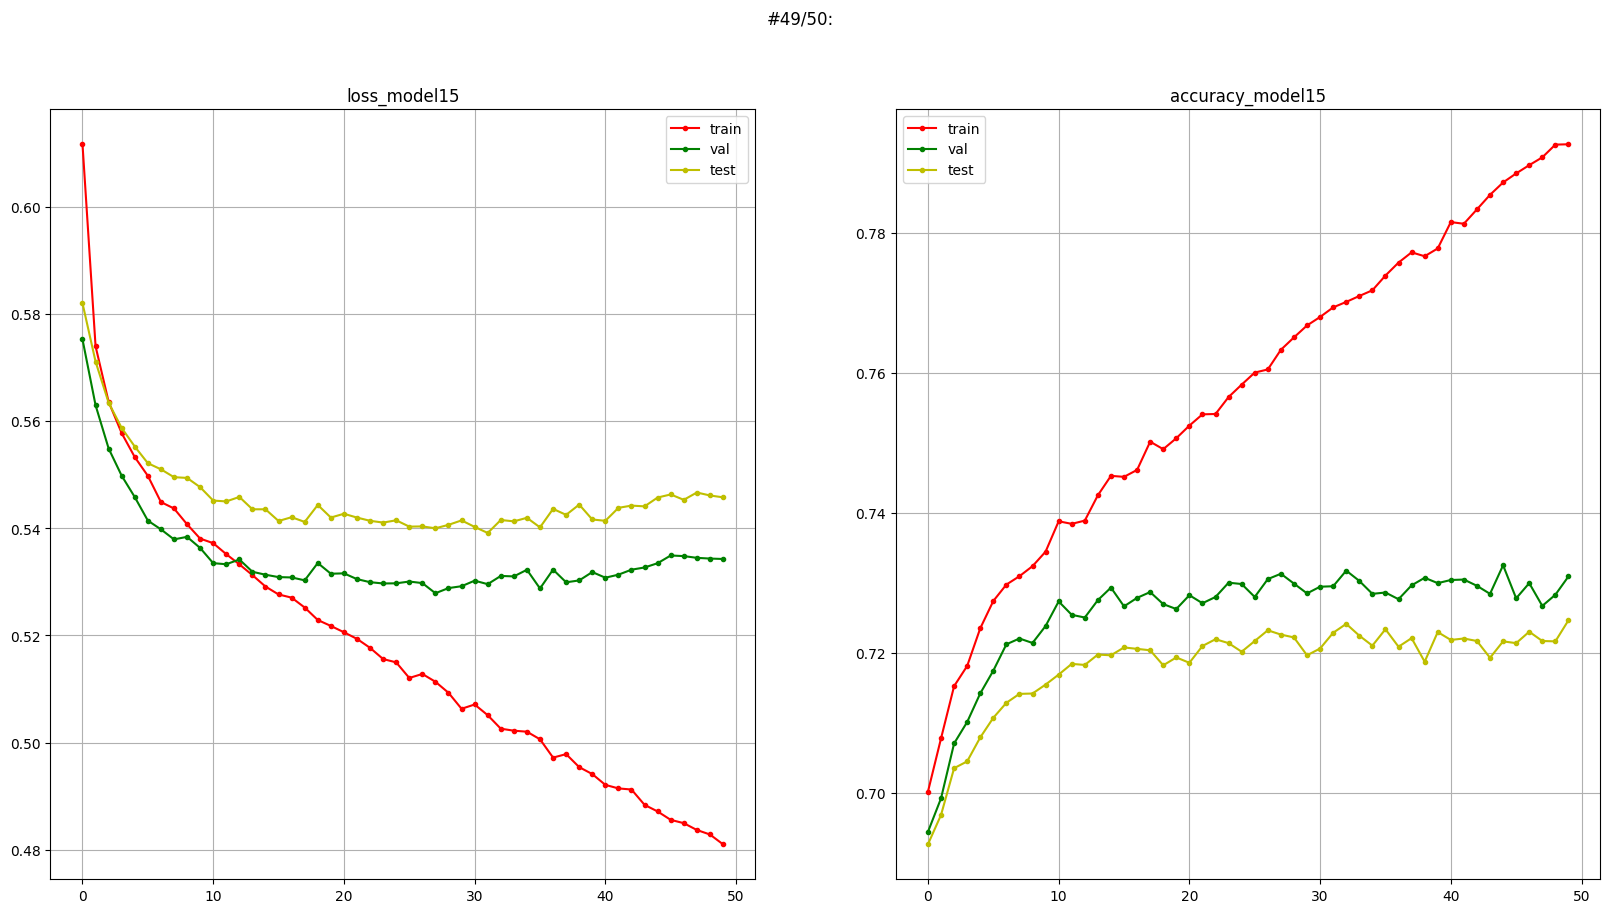

100%|███████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/it]


0:	learn: 0.6746717	test: 0.6695563	best: 0.6695563 (0)	total: 55.2ms	remaining: 1m 50s
10:	learn: 0.6893167	test: 0.6821137	best: 0.6821137 (10)	total: 152ms	remaining: 27.4s
20:	learn: 0.7009338	test: 0.6944161	best: 0.6944161 (20)	total: 246ms	remaining: 23.2s
30:	learn: 0.7094913	test: 0.6994518	best: 0.6994518 (30)	total: 340ms	remaining: 21.6s
40:	learn: 0.7143199	test: 0.7031489	best: 0.7032764 (38)	total: 426ms	remaining: 20.3s
50:	learn: 0.7181922	test: 0.7070372	best: 0.7070372 (50)	total: 511ms	remaining: 19.5s
60:	learn: 0.7236104	test: 0.7090133	best: 0.7090133 (60)	total: 598ms	remaining: 19s
70:	learn: 0.7276900	test: 0.7101606	best: 0.7101606 (67)	total: 683ms	remaining: 18.5s
80:	learn: 0.7311639	test: 0.7125829	best: 0.7125829 (80)	total: 768ms	remaining: 18.2s
90:	learn: 0.7348132	test: 0.7123916	best: 0.7131566 (88)	total: 854ms	remaining: 17.9s
100:	learn: 0.7379526	test: 0.7147501	best: 0.7152601 (99)	total: 941ms	remaining: 17.7s
110:	learn: 0.7406617	test: 0.715

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7711149	test: 0.7661270	best: 0.7661270 (0)	total: 10ms	remaining: 20s
10:	learn: 0.7917835	test: 0.7870984	best: 0.7870984 (10)	total: 95.5ms	remaining: 17.3s
20:	learn: 0.8049943	test: 0.7995283	best: 0.8002932 (19)	total: 180ms	remaining: 17s
30:	learn: 0.8162130	test: 0.8084523	best: 0.8084523 (30)	total: 266ms	remaining: 16.9s
40:	learn: 0.8259657	test: 0.8160377	best: 0.8160377 (40)	total: 352ms	remaining: 16.8s
50:	learn: 0.8328659	test: 0.8222208	best: 0.8226033 (49)	total: 438ms	remaining: 16.7s
60:	learn: 0.8399573	test: 0.8280852	best: 0.8280852 (60)	total: 525ms	remaining: 16.7s
70:	learn: 0.8462041	test: 0.8336308	best: 0.8336308 (70)	total: 612ms	remaining: 16.6s
80:	learn: 0.8517338	test: 0.8373279	best: 0.8373279 (80)	total: 699ms	remaining: 16.6s
90:	learn: 0.8552715	test: 0.8407700	best: 0.8407700 (90)	total: 787ms	remaining: 16.5s
100:	learn: 0.8594945	test: 0.8440209	best: 0.8440209 (100)	total: 874ms	remaining: 16.4s
110:	learn: 0.8634785	test: 0.847080

 20%|█████████                                    | 1/5 [00:19<01:16, 19.24s/it]

0:	learn: 0.7616012	test: 0.7539521	best: 0.7539521 (0)	total: 10.5ms	remaining: 21s
10:	learn: 0.7870506	test: 0.7833376	best: 0.7833376 (10)	total: 97.5ms	remaining: 17.6s
20:	learn: 0.8010741	test: 0.7971698	best: 0.7971698 (20)	total: 184ms	remaining: 17.3s
30:	learn: 0.8129462	test: 0.8075599	best: 0.8076874 (29)	total: 274ms	remaining: 17.4s
40:	learn: 0.8223802	test: 0.8166114	best: 0.8166114 (40)	total: 362ms	remaining: 17.3s
50:	learn: 0.8304118	test: 0.8250892	best: 0.8250892 (50)	total: 452ms	remaining: 17.3s
60:	learn: 0.8365311	test: 0.8301887	best: 0.8301887 (58)	total: 543ms	remaining: 17.3s
70:	learn: 0.8417102	test: 0.8334396	best: 0.8334396 (70)	total: 635ms	remaining: 17.2s
80:	learn: 0.8475108	test: 0.8381566	best: 0.8381566 (80)	total: 725ms	remaining: 17.2s
90:	learn: 0.8522756	test: 0.8409612	best: 0.8409612 (90)	total: 818ms	remaining: 17.2s
100:	learn: 0.8560683	test: 0.8428735	best: 0.8428735 (100)	total: 908ms	remaining: 17.1s
110:	learn: 0.8595264	test: 0.84

 40%|██████████████████                           | 2/5 [00:38<00:57, 19.24s/it]

0:	learn: 0.7823177	test: 0.7783019	best: 0.7783019 (0)	total: 10.5ms	remaining: 20.9s
10:	learn: 0.8060620	test: 0.8008669	best: 0.8008669 (10)	total: 105ms	remaining: 19s
20:	learn: 0.8227945	test: 0.8164202	best: 0.8164202 (20)	total: 222ms	remaining: 20.9s
30:	learn: 0.8331527	test: 0.8295512	best: 0.8295512 (30)	total: 314ms	remaining: 20s
40:	learn: 0.8438934	test: 0.8378378	best: 0.8378378 (40)	total: 426ms	remaining: 20.4s
50:	learn: 0.8531840	test: 0.8459332	best: 0.8461244 (49)	total: 524ms	remaining: 20s
60:	learn: 0.8593033	test: 0.8512876	best: 0.8512876 (60)	total: 641ms	remaining: 20.4s
70:	learn: 0.8651517	test: 0.8575344	best: 0.8575344 (70)	total: 747ms	remaining: 20.3s
80:	learn: 0.8714463	test: 0.8632075	best: 0.8632075 (79)	total: 849ms	remaining: 20.1s
90:	learn: 0.8753347	test: 0.8658848	best: 0.8658848 (90)	total: 955ms	remaining: 20s
100:	learn: 0.8792548	test: 0.8697093	best: 0.8697093 (100)	total: 1.05s	remaining: 19.8s
110:	learn: 0.8832228	test: 0.8734064	b

 60%|███████████████████████████                  | 3/5 [00:57<00:37, 18.97s/it]

0:	learn: 0.7715611	test: 0.7684855	best: 0.7684855 (0)	total: 9.84ms	remaining: 19.7s
10:	learn: 0.7908911	test: 0.7869072	best: 0.7869072 (10)	total: 97.7ms	remaining: 17.7s
20:	learn: 0.8035600	test: 0.7980622	best: 0.7986996 (19)	total: 186ms	remaining: 17.5s
30:	learn: 0.8155278	test: 0.8124044	best: 0.8124044 (30)	total: 273ms	remaining: 17.3s
40:	learn: 0.8261091	test: 0.8211372	best: 0.8211372 (40)	total: 361ms	remaining: 17.2s
50:	learn: 0.8351447	test: 0.8266828	best: 0.8268103 (48)	total: 449ms	remaining: 17.2s
60:	learn: 0.8418536	test: 0.8341407	best: 0.8341407 (60)	total: 537ms	remaining: 17.1s
70:	learn: 0.8472718	test: 0.8391764	best: 0.8391764 (70)	total: 627ms	remaining: 17s
80:	learn: 0.8522438	test: 0.8440847	best: 0.8440847 (80)	total: 714ms	remaining: 16.9s
90:	learn: 0.8571998	test: 0.8479730	best: 0.8479730 (90)	total: 804ms	remaining: 16.9s
100:	learn: 0.8617574	test: 0.8493753	best: 0.8493753 (100)	total: 893ms	remaining: 16.8s
110:	learn: 0.8651039	test: 0.85

 80%|████████████████████████████████████         | 4/5 [01:16<00:19, 19.15s/it]

0:	learn: 0.7666529	test: 0.7679755	best: 0.7679755 (0)	total: 9.77ms	remaining: 19.5s
10:	learn: 0.7903812	test: 0.7931540	best: 0.7931540 (10)	total: 100ms	remaining: 18.2s
20:	learn: 0.8052014	test: 0.8039266	best: 0.8040541 (19)	total: 190ms	remaining: 17.9s
30:	learn: 0.8162927	test: 0.8160377	best: 0.8160377 (30)	total: 280ms	remaining: 17.8s
40:	learn: 0.8254239	test: 0.8255992	best: 0.8255992 (40)	total: 371ms	remaining: 17.7s
50:	learn: 0.8324994	test: 0.8320372	best: 0.8320372 (50)	total: 463ms	remaining: 17.7s
60:	learn: 0.8396386	test: 0.8367542	best: 0.8368817 (59)	total: 554ms	remaining: 17.6s
70:	learn: 0.8450886	test: 0.8412162	best: 0.8412162 (70)	total: 645ms	remaining: 17.5s
80:	learn: 0.8508255	test: 0.8454870	best: 0.8454870 (80)	total: 733ms	remaining: 17.4s
90:	learn: 0.8568492	test: 0.8486741	best: 0.8486741 (90)	total: 822ms	remaining: 17.2s
100:	learn: 0.8607056	test: 0.8514788	best: 0.8514788 (99)	total: 912ms	remaining: 17.2s
110:	learn: 0.8645302	test: 0.85

100%|█████████████████████████████████████████████| 5/5 [01:35<00:00, 19.04s/it]


0:	learn: 0.7768517	test: 0.7715451	best: 0.7715451 (0)	total: 9.48ms	remaining: 19s
10:	learn: 0.7978391	test: 0.7950025	best: 0.7950025 (10)	total: 92.3ms	remaining: 16.7s
20:	learn: 0.8108427	test: 0.8084523	best: 0.8084523 (20)	total: 173ms	remaining: 16.3s
30:	learn: 0.8231770	test: 0.8187787	best: 0.8187787 (30)	total: 258ms	remaining: 16.4s
40:	learn: 0.8330252	test: 0.8261729	best: 0.8261729 (40)	total: 344ms	remaining: 16.4s
50:	learn: 0.8416465	test: 0.8329934	best: 0.8329934 (50)	total: 429ms	remaining: 16.4s
60:	learn: 0.8491682	test: 0.8391764	best: 0.8391764 (60)	total: 515ms	remaining: 16.4s
70:	learn: 0.8540764	test: 0.8430010	best: 0.8430010 (70)	total: 601ms	remaining: 16.3s
80:	learn: 0.8605463	test: 0.8486104	best: 0.8486104 (80)	total: 685ms	remaining: 16.2s
90:	learn: 0.8647533	test: 0.8516063	best: 0.8516701 (89)	total: 769ms	remaining: 16.1s
100:	learn: 0.8698049	test: 0.8544748	best: 0.8547935 (99)	total: 854ms	remaining: 16.1s
110:	learn: 0.8736136	test: 0.857

In [203]:
dataset_folder = 'higgs_small'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(15, ResNet, resnet_params, optimizer_params, data_model, train_params, metric)
results_cb_learning = CatBoostNLearning(results_models_learning, catboost_params, data_cb, metric)

In [205]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7217746047934727
distill_0 : 0.7264150943396226 ---------> 0.7211116777154513
model_1_metric : 0.7199388067312595
distill_1 : 0.7264150943396226 ---------> 0.7208567057623662
model_2_metric : 0.720754716981132
distill_2 : 0.7264150943396226 ---------> 0.7191738908720041
model_3_metric : 0.7213666496685365
distill_3 : 0.7264150943396226 ---------> 0.7232024477307496
model_4_metric : 0.7241713411524733
distill_4 : 0.7264150943396226 ---------> 0.7240183579806221
averaged ensembles accuracy :  0.7224545300016999


In [214]:
# Aloi Parameters
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 8192,
    'num_epochs' : 120,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

resnet_params = {
    'd_numerical' : 128,
    'activation' : 'relu',
    'd' : 466,
    'd_embedding' : None,
    'categories' : None,
    'd_hidden_factor' : 3.395533939757561,
    'hidden_dropout' : 0.1521578761567568,
    'n_layers' : 7,
    'normalization' : 'batchnorm',
    'residual_dropout' : 0.0,
    'd_out' : 1000
}

optimizer_params = {
    'lr' : 2.055922372891508e-05,
    'weight_decay' : 0.0
}

catboost_params = {
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

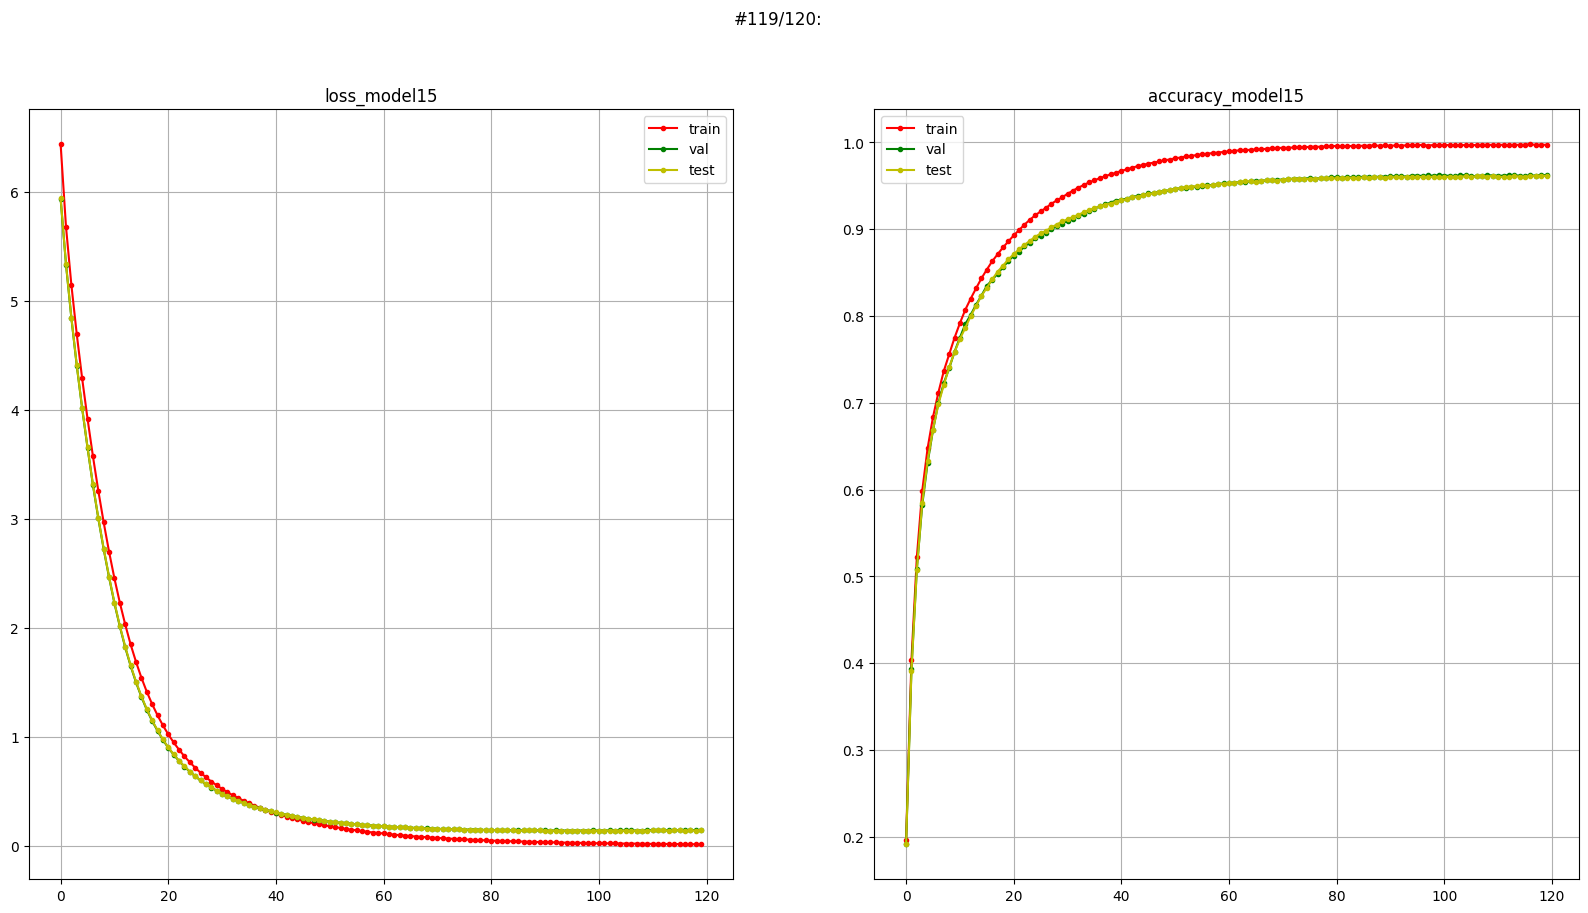

100%|█████████████████████████████████████████| 120/120 [06:20<00:00,  3.17s/it]


Learning rate set to 0.119146
0:	learn: 0.0494792	test: 0.0494792	best: 0.0494792 (0)	total: 7.44s	remaining: 4h 7m 53s
10:	learn: 0.5054253	test: 0.4928241	best: 0.4928241 (10)	total: 1m 13s	remaining: 3h 42m 54s
20:	learn: 0.6959201	test: 0.6759838	best: 0.6759838 (20)	total: 2m 21s	remaining: 3h 41m 46s
30:	learn: 0.7710648	test: 0.7495370	best: 0.7495370 (30)	total: 3m 29s	remaining: 3h 41m 39s
40:	learn: 0.8131366	test: 0.7893519	best: 0.7893519 (40)	total: 4m 38s	remaining: 3h 41m 24s
50:	learn: 0.8368200	test: 0.8118634	best: 0.8118634 (50)	total: 5m 45s	remaining: 3h 39m 44s
60:	learn: 0.8550203	test: 0.8276620	best: 0.8276620 (60)	total: 6m 51s	remaining: 3h 38m 7s
70:	learn: 0.8679687	test: 0.8390625	best: 0.8390625 (70)	total: 7m 57s	remaining: 3h 36m 11s
80:	learn: 0.8780961	test: 0.8491898	best: 0.8491898 (80)	total: 9m	remaining: 3h 33m 23s
90:	learn: 0.8881655	test: 0.8570023	best: 0.8570023 (90)	total: 10m 4s	remaining: 3h 31m 17s
100:	learn: 0.8977720	test: 0.8646991	b

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Learning rate set to 0.119146
0:	learn: 0.0279080	test: 0.0280093	best: 0.0280093 (0)	total: 5.96s	remaining: 3h 18m 40s
10:	learn: 0.5141348	test: 0.4973380	best: 0.4973380 (10)	total: 1m 6s	remaining: 3h 19m 36s
20:	learn: 0.7054398	test: 0.6891204	best: 0.6891204 (20)	total: 2m 10s	remaining: 3h 25m 12s
30:	learn: 0.7985532	test: 0.7751736	best: 0.7751736 (30)	total: 3m 14s	remaining: 3h 26m 4s
40:	learn: 0.8278791	test: 0.8043981	best: 0.8043981 (40)	total: 4m 20s	remaining: 3h 27m 5s
50:	learn: 0.8512153	test: 0.8270255	best: 0.8270255 (50)	total: 5m 24s	remaining: 3h 26m 24s
60:	learn: 0.8689381	test: 0.8436343	best: 0.8436343 (60)	total: 6m 28s	remaining: 3h 25m 35s
70:	learn: 0.8811487	test: 0.8545718	best: 0.8545718 (70)	total: 7m 32s	remaining: 3h 24m 49s
80:	learn: 0.8928096	test: 0.8665509	best: 0.8665509 (80)	total: 8m 35s	remaining: 3h 23m 39s
90:	learn: 0.9024740	test: 0.8757523	best: 0.8757523 (90)	total: 9m 37s	remaining: 3h 21m 59s
100:	learn: 0.9102575	test: 0.881018

 50%|███████████████████                   | 1/2 [3:25:52<3:25:52, 12352.85s/it]

Learning rate set to 0.119146
0:	learn: 0.0278067	test: 0.0274884	best: 0.0274884 (0)	total: 6.13s	remaining: 3h 24m 18s
10:	learn: 0.5172454	test: 0.5017940	best: 0.5017940 (10)	total: 1m 6s	remaining: 3h 21m 26s
20:	learn: 0.7281539	test: 0.7072917	best: 0.7072917 (20)	total: 2m 10s	remaining: 3h 25m 44s
30:	learn: 0.8031829	test: 0.7807292	best: 0.7807292 (30)	total: 3m 15s	remaining: 3h 27m 24s
40:	learn: 0.8377315	test: 0.8156250	best: 0.8156250 (40)	total: 4m 22s	remaining: 3h 29m 6s
50:	learn: 0.8590856	test: 0.8355903	best: 0.8355903 (50)	total: 5m 27s	remaining: 3h 28m 36s
60:	learn: 0.8753906	test: 0.8501736	best: 0.8501736 (60)	total: 6m 31s	remaining: 3h 27m 11s
70:	learn: 0.8857784	test: 0.8594907	best: 0.8594907 (70)	total: 7m 32s	remaining: 3h 25m 6s
80:	learn: 0.8960359	test: 0.8677662	best: 0.8677662 (80)	total: 8m 36s	remaining: 3h 23m 47s
90:	learn: 0.9034144	test: 0.8765046	best: 0.8765046 (90)	total: 9m 39s	remaining: 3h 22m 27s
100:	learn: 0.9108652	test: 0.882754

100%|████████████████████████████████████████| 2/2 [6:50:48<00:00, 12324.02s/it]


Learning rate set to 0.119146
0:	learn: 0.0278791	test: 0.0277199	best: 0.0277199 (0)	total: 6.05s	remaining: 3h 21m 42s
10:	learn: 0.5063802	test: 0.4899884	best: 0.4899884 (10)	total: 1m 6s	remaining: 3h 20m 51s
20:	learn: 0.7016348	test: 0.6821759	best: 0.6821759 (20)	total: 2m 10s	remaining: 3h 24m 46s
30:	learn: 0.7884115	test: 0.7703125	best: 0.7703125 (30)	total: 3m 14s	remaining: 3h 25m 57s
40:	learn: 0.8267650	test: 0.8050347	best: 0.8050347 (40)	total: 4m 18s	remaining: 3h 26m 3s
50:	learn: 0.8494936	test: 0.8266782	best: 0.8266782 (50)	total: 5m 21s	remaining: 3h 24m 57s
60:	learn: 0.8671441	test: 0.8438079	best: 0.8438079 (60)	total: 6m 25s	remaining: 3h 23m 58s
70:	learn: 0.8782841	test: 0.8529514	best: 0.8529514 (70)	total: 7m 27s	remaining: 3h 22m 31s
80:	learn: 0.8894965	test: 0.8637153	best: 0.8637153 (80)	total: 8m 31s	remaining: 3h 21m 52s
90:	learn: 0.8988860	test: 0.8737269	best: 0.8737269 (90)	total: 9m 33s	remaining: 3h 20m 32s
100:	learn: 0.9062355	test: 0.87974

In [221]:
dataset_folder = 'aloi'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='standard')
results_models_learning = LearnNModels(15, ResNet, resnet_params, optimizer_params, data_model, train_params, metric)
results_cb_learning = CatBoostNLearning(results_models_learning, catboost_params, data_cb, metric, N=2)

In [222]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.9619907407407408
distill_0 : 0.9452777777777778 ---------> 0.9518981481481481
model_1_metric : 0.9614814814814815
distill_1 : 0.9452777777777778 ---------> 0.9512962962962963
averaged ensembles accuracy :  0.9512808641975309


In [216]:
cb = CatBoostClassifier(**catboost_params)
cb.fit(data_cb['X_train'], data_cb['y_train'], eval_set = (data_cb['X_val'], data_cb['y_val']))

Learning rate set to 0.119146
0:	learn: 0.0494792	test: 0.0494792	best: 0.0494792 (0)	total: 7.33s	remaining: 4h 4m 14s
10:	learn: 0.5054253	test: 0.4928241	best: 0.4928241 (10)	total: 1m 9s	remaining: 3h 30m 45s
20:	learn: 0.6959201	test: 0.6759838	best: 0.6759838 (20)	total: 2m 13s	remaining: 3h 29m 58s
30:	learn: 0.7710648	test: 0.7495370	best: 0.7495370 (30)	total: 3m 19s	remaining: 3h 31m 1s
40:	learn: 0.8131366	test: 0.7893519	best: 0.7893519 (40)	total: 4m 25s	remaining: 3h 31m 43s
50:	learn: 0.8368200	test: 0.8118634	best: 0.8118634 (50)	total: 5m 32s	remaining: 3h 31m 45s
60:	learn: 0.8550203	test: 0.8276620	best: 0.8276620 (60)	total: 6m 37s	remaining: 3h 30m 22s
70:	learn: 0.8679687	test: 0.8390625	best: 0.8390625 (70)	total: 7m 40s	remaining: 3h 28m 35s
80:	learn: 0.8780961	test: 0.8491898	best: 0.8491898 (80)	total: 8m 42s	remaining: 3h 26m 28s
90:	learn: 0.8881655	test: 0.8570023	best: 0.8570023 (90)	total: 9m 43s	remaining: 3h 24m 5s
100:	learn: 0.8977720	test: 0.8646991

In [217]:
preds = cb.predict(data_cb['X_test'])
print(accuracy_score(data_cb['y_test'], preds))

0.9452777777777778


In [138]:
train_params = {
    'batch_size' : 256,
    'eval_batch_size' : 8192,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

resnet_params = {
    'd_numerical' : 8,
    'activation' : 'relu',
    'd' : 168,
    'd_embedding' : None,
    'categories' : None,
    'd_hidden_factor' : 2.98304144273798,
    'hidden_dropout' : 0.4456540496119129,
    'n_layers' : 3,
    'normalization' : 'batchnorm',
    'residual_dropout' : 0.0,
    'd_out' : 1
}

optimizer_params = {
    'lr' : 0.001759485551174299,
    'weight_decay' : 0.0009508455223812318
}

catboost_params = {
    'bagging_temperature' : 0.004350736313860622,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.157639995907031,
    'leaf_estimation_iterations' : 4,
    'learning_rate' : 0.1021076879315874,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

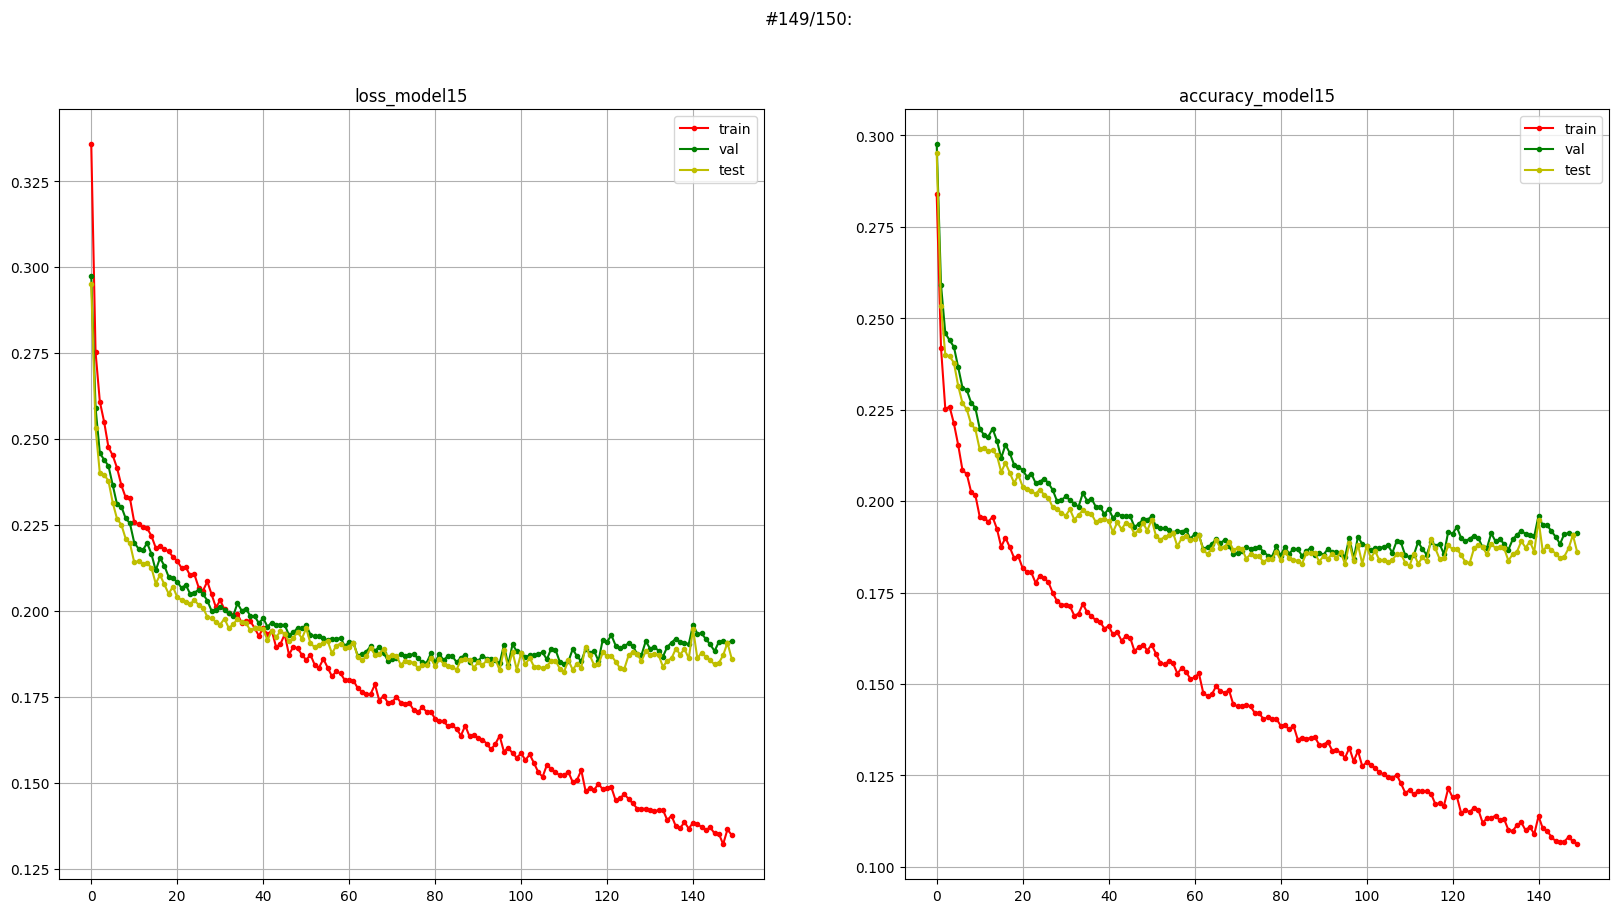

100%|█████████████████████████████████████████| 150/150 [02:26<00:00,  1.03it/s]


0:	learn: 0.9361596	test: 0.9365706	best: 0.9365706 (0)	total: 83.9ms	remaining: 2m 47s
10:	learn: 0.5903575	test: 0.6043515	best: 0.6043515 (10)	total: 796ms	remaining: 2m 23s
20:	learn: 0.4907550	test: 0.5116647	best: 0.5116647 (20)	total: 1.5s	remaining: 2m 21s
30:	learn: 0.4548279	test: 0.4788678	best: 0.4788678 (30)	total: 2.2s	remaining: 2m 20s
40:	learn: 0.4322337	test: 0.4612566	best: 0.4612566 (40)	total: 2.91s	remaining: 2m 19s
50:	learn: 0.4180322	test: 0.4510834	best: 0.4510834 (50)	total: 3.61s	remaining: 2m 18s
60:	learn: 0.4077928	test: 0.4452423	best: 0.4452423 (60)	total: 4.26s	remaining: 2m 15s
70:	learn: 0.3968504	test: 0.4364781	best: 0.4364781 (70)	total: 4.97s	remaining: 2m 15s
80:	learn: 0.3911905	test: 0.4334863	best: 0.4334863 (80)	total: 5.45s	remaining: 2m 9s
90:	learn: 0.3870045	test: 0.4308548	best: 0.4308548 (90)	total: 5.91s	remaining: 2m 4s
100:	learn: 0.3827532	test: 0.4287226	best: 0.4287226 (100)	total: 6.43s	remaining: 2m
110:	learn: 0.3789732	test: 

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.8355833	test: 0.8216925	best: 0.8216925 (0)	total: 74.2ms	remaining: 2m 28s
10:	learn: 0.4502295	test: 0.4430633	best: 0.4430633 (10)	total: 793ms	remaining: 2m 23s
20:	learn: 0.3267536	test: 0.3227117	best: 0.3227117 (20)	total: 1.51s	remaining: 2m 21s
30:	learn: 0.2801172	test: 0.2788704	best: 0.2788704 (30)	total: 2.22s	remaining: 2m 20s
40:	learn: 0.2529719	test: 0.2550248	best: 0.2550248 (40)	total: 2.94s	remaining: 2m 20s
50:	learn: 0.2469640	test: 0.2501665	best: 0.2501665 (50)	total: 3.34s	remaining: 2m 7s
60:	learn: 0.2383811	test: 0.2423717	best: 0.2423717 (60)	total: 3.69s	remaining: 1m 57s
70:	learn: 0.2281088	test: 0.2335984	best: 0.2335984 (70)	total: 4.28s	remaining: 1m 56s
80:	learn: 0.2175455	test: 0.2250040	best: 0.2250040 (80)	total: 4.93s	remaining: 1m 56s
90:	learn: 0.2078708	test: 0.2180827	best: 0.2180827 (90)	total: 5.66s	remaining: 1m 58s
100:	learn: 0.1992587	test: 0.2112728	best: 0.2112728 (100)	total: 6.38s	remaining: 1m 59s
110:	learn: 0.1953372

 20%|█████████                                    | 1/5 [00:32<02:09, 32.47s/it]

0:	learn: 0.8173855	test: 0.8054934	best: 0.8054934 (0)	total: 73.2ms	remaining: 2m 26s
10:	learn: 0.4440746	test: 0.4423977	best: 0.4423977 (10)	total: 794ms	remaining: 2m 23s
20:	learn: 0.3173895	test: 0.3198363	best: 0.3198363 (20)	total: 1.51s	remaining: 2m 22s
30:	learn: 0.2676796	test: 0.2738889	best: 0.2738889 (30)	total: 2.23s	remaining: 2m 21s
40:	learn: 0.2419960	test: 0.2509195	best: 0.2509195 (40)	total: 2.94s	remaining: 2m 20s
50:	learn: 0.2331493	test: 0.2433782	best: 0.2433782 (50)	total: 3.4s	remaining: 2m 10s
60:	learn: 0.2244556	test: 0.2361502	best: 0.2361502 (60)	total: 3.87s	remaining: 2m 3s
70:	learn: 0.2210387	test: 0.2337135	best: 0.2337135 (70)	total: 4.09s	remaining: 1m 51s
80:	learn: 0.2143021	test: 0.2271313	best: 0.2271313 (80)	total: 4.49s	remaining: 1m 46s
90:	learn: 0.2044237	test: 0.2189047	best: 0.2189047 (90)	total: 5.14s	remaining: 1m 47s
100:	learn: 0.2016514	test: 0.2165620	best: 0.2165620 (100)	total: 5.47s	remaining: 1m 42s
110:	learn: 0.1939797	

 40%|██████████████████                           | 2/5 [01:19<02:03, 41.30s/it]

0:	learn: 0.8303576	test: 0.8154218	best: 0.8154218 (0)	total: 74.7ms	remaining: 2m 29s
10:	learn: 0.4475256	test: 0.4422957	best: 0.4422957 (10)	total: 799ms	remaining: 2m 24s
20:	learn: 0.3202263	test: 0.3205823	best: 0.3205823 (20)	total: 1.52s	remaining: 2m 23s
30:	learn: 0.2722602	test: 0.2768166	best: 0.2768166 (30)	total: 2.24s	remaining: 2m 22s
40:	learn: 0.2469104	test: 0.2541913	best: 0.2541913 (40)	total: 2.96s	remaining: 2m 21s
50:	learn: 0.2352975	test: 0.2446162	best: 0.2446162 (50)	total: 3.49s	remaining: 2m 13s
60:	learn: 0.2281117	test: 0.2382078	best: 0.2382078 (60)	total: 3.84s	remaining: 2m 2s
70:	learn: 0.2131284	test: 0.2258638	best: 0.2258638 (70)	total: 4.57s	remaining: 2m 4s
80:	learn: 0.2016439	test: 0.2162625	best: 0.2162625 (80)	total: 5.29s	remaining: 2m 5s
90:	learn: 0.1942383	test: 0.2100974	best: 0.2100974 (90)	total: 6.01s	remaining: 2m 6s
100:	learn: 0.1859569	test: 0.2034883	best: 0.2034883 (100)	total: 6.62s	remaining: 2m 4s
110:	learn: 0.1790943	tes

 60%|███████████████████████████                  | 3/5 [02:08<01:28, 44.44s/it]

0:	learn: 0.8260025	test: 0.8126821	best: 0.8126821 (0)	total: 75ms	remaining: 2m 29s
10:	learn: 0.4460450	test: 0.4425102	best: 0.4425102 (10)	total: 802ms	remaining: 2m 24s
20:	learn: 0.3108954	test: 0.3127197	best: 0.3127197 (20)	total: 1.52s	remaining: 2m 23s
30:	learn: 0.2627749	test: 0.2682153	best: 0.2682153 (30)	total: 2.25s	remaining: 2m 22s
40:	learn: 0.2372373	test: 0.2455447	best: 0.2455447 (40)	total: 2.97s	remaining: 2m 21s
50:	learn: 0.2304937	test: 0.2395834	best: 0.2395828 (49)	total: 3.32s	remaining: 2m 6s
60:	learn: 0.2180734	test: 0.2290655	best: 0.2290655 (60)	total: 3.85s	remaining: 2m 2s
70:	learn: 0.2094826	test: 0.2223273	best: 0.2223273 (70)	total: 4.32s	remaining: 1m 57s
80:	learn: 0.1998532	test: 0.2140926	best: 0.2140926 (80)	total: 4.98s	remaining: 1m 58s
90:	learn: 0.1894965	test: 0.2069644	best: 0.2069644 (90)	total: 5.71s	remaining: 1m 59s
100:	learn: 0.1835048	test: 0.2020500	best: 0.2020500 (100)	total: 6.37s	remaining: 1m 59s
110:	learn: 0.1813674	te

 80%|████████████████████████████████████         | 4/5 [02:58<00:46, 46.72s/it]

0:	learn: 0.8348473	test: 0.8210708	best: 0.8210708 (0)	total: 73.3ms	remaining: 2m 26s
10:	learn: 0.4522623	test: 0.4514470	best: 0.4514470 (10)	total: 796ms	remaining: 2m 23s
20:	learn: 0.3187620	test: 0.3232072	best: 0.3232072 (20)	total: 1.51s	remaining: 2m 22s
30:	learn: 0.2679896	test: 0.2763498	best: 0.2763498 (30)	total: 2.23s	remaining: 2m 22s
40:	learn: 0.2431658	test: 0.2546508	best: 0.2546508 (40)	total: 2.95s	remaining: 2m 21s
50:	learn: 0.2288073	test: 0.2419736	best: 0.2419736 (50)	total: 3.61s	remaining: 2m 18s
60:	learn: 0.2164152	test: 0.2318104	best: 0.2318104 (60)	total: 4.17s	remaining: 2m 12s
70:	learn: 0.2096236	test: 0.2259641	best: 0.2259641 (70)	total: 4.64s	remaining: 2m 6s
80:	learn: 0.1983627	test: 0.2170805	best: 0.2170805 (80)	total: 5.37s	remaining: 2m 7s
90:	learn: 0.1895812	test: 0.2100916	best: 0.2100916 (90)	total: 6.1s	remaining: 2m 7s
100:	learn: 0.1842347	test: 0.2053997	best: 0.2053997 (100)	total: 6.82s	remaining: 2m 8s
110:	learn: 0.1804569	tes

100%|█████████████████████████████████████████████| 5/5 [03:42<00:00, 44.41s/it]


tensor([ 1.0192,  0.6730, -0.2860,  ..., -0.9996,  1.3922, -0.9276],
       device='cuda:0')
0:	learn: 0.8267086	test: 0.8127961	best: 0.8127961 (0)	total: 73.6ms	remaining: 2m 27s
10:	learn: 0.4453973	test: 0.4404874	best: 0.4404874 (10)	total: 797ms	remaining: 2m 24s
20:	learn: 0.3162074	test: 0.3169757	best: 0.3169757 (20)	total: 1.52s	remaining: 2m 23s
30:	learn: 0.2665730	test: 0.2698342	best: 0.2698342 (30)	total: 2.24s	remaining: 2m 22s
40:	learn: 0.2435034	test: 0.2490465	best: 0.2490465 (40)	total: 2.96s	remaining: 2m 21s
50:	learn: 0.2333885	test: 0.2401694	best: 0.2401694 (50)	total: 3.37s	remaining: 2m 8s
60:	learn: 0.2204397	test: 0.2291055	best: 0.2291047 (59)	total: 3.91s	remaining: 2m 4s
70:	learn: 0.2094510	test: 0.2198420	best: 0.2198420 (70)	total: 4.57s	remaining: 2m 4s
80:	learn: 0.2000577	test: 0.2114321	best: 0.2114321 (80)	total: 5.23s	remaining: 2m 3s
90:	learn: 0.1895019	test: 0.2026620	best: 0.2026620 (90)	total: 5.96s	remaining: 2m 4s
100:	learn: 0.1810914	t

In [139]:
dataset_folder = 'california_housing'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(15, ResNet, resnet_params, optimizer_params, data_model, train_params, metric, regression=True)
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, regression=True)

In [140]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 0.49785940412325
distill_0 : 0.4483092759329933 ---------> 0.4866872637460586
model_1_metric : 0.4957263849388545
distill_1 : 0.4483092759329933 ---------> 0.4868667995082422
model_2_metric : 0.5010884669510207
distill_2 : 0.4483092759329933 ---------> 0.4821639495263349
model_3_metric : 0.49492150162900106
distill_3 : 0.4483092759329933 ---------> 0.4855872495294275
model_4_metric : 0.4911023672611817
distill_4 : 0.4483092759329933 ---------> 0.48315052622664734
averaged ensembles accuracy :  0.48457419183037403


In [11]:
train_params = {
    'batch_size' : 1024,
    'eval_batch_size' : 8192,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

resnet_params = {
    'd_numerical' : 90,
    'activation' : 'relu',
    'd' : 467,
    'd_embedding' : None,
    'categories' : None,
    'd_hidden_factor' : 2.061832845752671,
    'hidden_dropout' : 0.496305297137531,
    'n_layers' : 3,
    'normalization' : 'batchnorm',
    'residual_dropout' : 0.04719482253220739,
    'd_out' : 1
}

optimizer_params = {
    'lr' : 1.716966464351664e-05,
    'weight_decay' : 4.681426841176751e-06
}

catboost_params = {
    'bagging_temperature' : 0.8324949854063162,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 1.077941041711693,
    'leaf_estimation_iterations' : 2,
    'learning_rate' : 0.04659912850277395,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

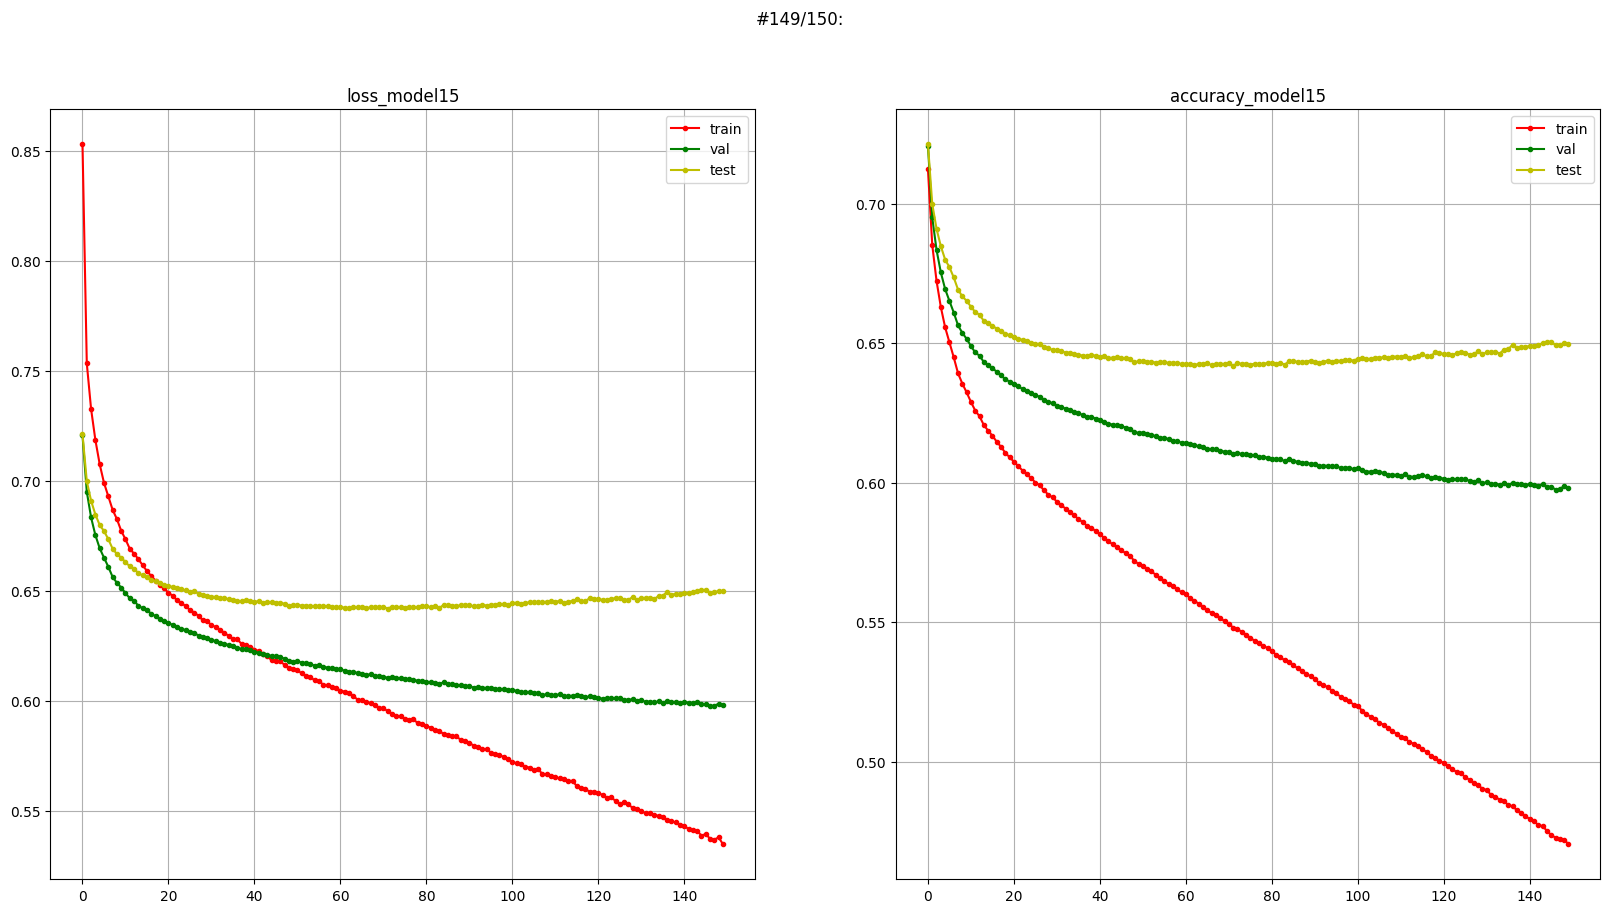

100%|█████████████████████████████████████████| 150/150 [10:08<00:00,  4.06s/it]


0:	learn: 0.9914147	test: 0.9967809	best: 0.9967809 (0)	total: 21.2ms	remaining: 42.4s
10:	learn: 0.9324685	test: 0.9388348	best: 0.9388348 (10)	total: 169ms	remaining: 30.5s
20:	learn: 0.9001344	test: 0.9072233	best: 0.9072233 (20)	total: 319ms	remaining: 30s
30:	learn: 0.8800481	test: 0.8877585	best: 0.8877585 (30)	total: 469ms	remaining: 29.8s
40:	learn: 0.8667816	test: 0.8750099	best: 0.8750099 (40)	total: 619ms	remaining: 29.6s
50:	learn: 0.8572563	test: 0.8662189	best: 0.8662189 (50)	total: 772ms	remaining: 29.5s
60:	learn: 0.8499228	test: 0.8598097	best: 0.8598097 (60)	total: 925ms	remaining: 29.4s
70:	learn: 0.8441134	test: 0.8547046	best: 0.8547046 (70)	total: 1.08s	remaining: 29.3s
80:	learn: 0.8388913	test: 0.8506284	best: 0.8506284 (80)	total: 1.23s	remaining: 29.2s
90:	learn: 0.8344994	test: 0.8473707	best: 0.8473707 (90)	total: 1.39s	remaining: 29.2s
100:	learn: 0.8307917	test: 0.8446539	best: 0.8446539 (100)	total: 1.55s	remaining: 29.1s
110:	learn: 0.8271697	test: 0.842

  0%|                                                     | 0/5 [00:00<?, ?it/s]Warning: less than 75% gpu memory available for training. Free: 272.625 Total: 16108.75


0:	learn: 0.6726202	test: 0.6631951	best: 0.6631951 (0)	total: 15.8ms	remaining: 31.6s
10:	learn: 0.5810631	test: 0.5705693	best: 0.5705693 (10)	total: 163ms	remaining: 29.4s
20:	learn: 0.5278905	test: 0.5167104	best: 0.5167104 (20)	total: 312ms	remaining: 29.4s
30:	learn: 0.4938458	test: 0.4823840	best: 0.4823840 (30)	total: 464ms	remaining: 29.5s
40:	learn: 0.4707322	test: 0.4590496	best: 0.4590496 (40)	total: 621ms	remaining: 29.7s
50:	learn: 0.4537822	test: 0.4418313	best: 0.4418313 (50)	total: 777ms	remaining: 29.7s
60:	learn: 0.4406167	test: 0.4286650	best: 0.4286650 (60)	total: 933ms	remaining: 29.6s
70:	learn: 0.4301718	test: 0.4183284	best: 0.4183284 (70)	total: 1.09s	remaining: 29.7s
80:	learn: 0.4214244	test: 0.4099038	best: 0.4099038 (80)	total: 1.25s	remaining: 29.7s
90:	learn: 0.4136891	test: 0.4023225	best: 0.4023225 (90)	total: 1.41s	remaining: 29.6s
100:	learn: 0.4067687	test: 0.3957873	best: 0.3957873 (100)	total: 1.57s	remaining: 29.5s
110:	learn: 0.4005972	test: 0.3

 20%|█████████                                    | 1/5 [00:32<02:11, 32.82s/it]Warning: less than 75% gpu memory available for training. Free: 272.625 Total: 16108.75


0:	learn: 0.6693223	test: 0.6602975	best: 0.6602975 (0)	total: 15.2ms	remaining: 30.5s
10:	learn: 0.5784528	test: 0.5684272	best: 0.5684272 (10)	total: 162ms	remaining: 29.2s
20:	learn: 0.5255152	test: 0.5148187	best: 0.5148187 (20)	total: 309ms	remaining: 29.1s
30:	learn: 0.4915506	test: 0.4804388	best: 0.4804388 (30)	total: 460ms	remaining: 29.2s
40:	learn: 0.4679489	test: 0.4566297	best: 0.4566297 (40)	total: 611ms	remaining: 29.2s
50:	learn: 0.4509180	test: 0.4394035	best: 0.4394035 (50)	total: 767ms	remaining: 29.3s
60:	learn: 0.4374181	test: 0.4258898	best: 0.4258898 (60)	total: 919ms	remaining: 29.2s
70:	learn: 0.4265447	test: 0.4151638	best: 0.4151638 (70)	total: 1.08s	remaining: 29.2s
80:	learn: 0.4176643	test: 0.4064851	best: 0.4064851 (80)	total: 1.23s	remaining: 29.2s
90:	learn: 0.4101274	test: 0.3992344	best: 0.3992344 (90)	total: 1.39s	remaining: 29.2s
100:	learn: 0.4035361	test: 0.3928678	best: 0.3928678 (100)	total: 1.55s	remaining: 29.1s
110:	learn: 0.3972470	test: 0.3

 40%|██████████████████                           | 2/5 [01:06<01:39, 33.07s/it]Warning: less than 75% gpu memory available for training. Free: 272.625 Total: 16108.75


0:	learn: 0.6677731	test: 0.6576492	best: 0.6576492 (0)	total: 15.2ms	remaining: 30.3s
10:	learn: 0.5769068	test: 0.5658030	best: 0.5658030 (10)	total: 159ms	remaining: 28.8s
20:	learn: 0.5241228	test: 0.5122942	best: 0.5122942 (20)	total: 307ms	remaining: 29s
30:	learn: 0.4903417	test: 0.4781726	best: 0.4781726 (30)	total: 458ms	remaining: 29.1s
40:	learn: 0.4670709	test: 0.4547116	best: 0.4547116 (40)	total: 608ms	remaining: 29.1s
50:	learn: 0.4499338	test: 0.4374605	best: 0.4374605 (50)	total: 763ms	remaining: 29.2s
60:	learn: 0.4371139	test: 0.4246651	best: 0.4246651 (60)	total: 917ms	remaining: 29.2s
70:	learn: 0.4262396	test: 0.4139312	best: 0.4139312 (70)	total: 1.07s	remaining: 29.2s
80:	learn: 0.4173536	test: 0.4052129	best: 0.4052129 (80)	total: 1.23s	remaining: 29.1s
90:	learn: 0.4096987	test: 0.3977372	best: 0.3977372 (90)	total: 1.39s	remaining: 29.1s
100:	learn: 0.4032186	test: 0.3916680	best: 0.3916680 (100)	total: 1.54s	remaining: 29s
110:	learn: 0.3972674	test: 0.38597

 60%|███████████████████████████                  | 3/5 [01:39<01:06, 33.12s/it]Warning: less than 75% gpu memory available for training. Free: 272.625 Total: 16108.75


0:	learn: 0.6712208	test: 0.6610972	best: 0.6610972 (0)	total: 14.9ms	remaining: 29.8s
10:	learn: 0.5794944	test: 0.5683854	best: 0.5683854 (10)	total: 160ms	remaining: 29s
20:	learn: 0.5268463	test: 0.5152043	best: 0.5152043 (20)	total: 307ms	remaining: 28.9s
30:	learn: 0.4928585	test: 0.4809063	best: 0.4809063 (30)	total: 457ms	remaining: 29s
40:	learn: 0.4698384	test: 0.4576410	best: 0.4576410 (40)	total: 607ms	remaining: 29s
50:	learn: 0.4530971	test: 0.4408455	best: 0.4408455 (50)	total: 762ms	remaining: 29.1s
60:	learn: 0.4399989	test: 0.4278527	best: 0.4278527 (60)	total: 918ms	remaining: 29.2s
70:	learn: 0.4295588	test: 0.4175136	best: 0.4175136 (70)	total: 1.07s	remaining: 29.2s
80:	learn: 0.4207008	test: 0.4087672	best: 0.4087672 (80)	total: 1.23s	remaining: 29.2s
90:	learn: 0.4129344	test: 0.4012299	best: 0.4012299 (90)	total: 1.39s	remaining: 29.1s
100:	learn: 0.4064033	test: 0.3950331	best: 0.3950331 (100)	total: 1.55s	remaining: 29.1s
110:	learn: 0.4006713	test: 0.3895962

 80%|████████████████████████████████████         | 4/5 [02:12<00:33, 33.19s/it]Warning: less than 75% gpu memory available for training. Free: 272.625 Total: 16108.75


0:	learn: 0.6712476	test: 0.6616327	best: 0.6616327 (0)	total: 15.4ms	remaining: 30.7s
10:	learn: 0.5803748	test: 0.5695713	best: 0.5695713 (10)	total: 160ms	remaining: 28.9s
20:	learn: 0.5271591	test: 0.5157439	best: 0.5157439 (20)	total: 309ms	remaining: 29.1s
30:	learn: 0.4936809	test: 0.4818940	best: 0.4818940 (30)	total: 459ms	remaining: 29.1s
40:	learn: 0.4703633	test: 0.4583271	best: 0.4583271 (40)	total: 610ms	remaining: 29.1s
50:	learn: 0.4534229	test: 0.4411832	best: 0.4411832 (50)	total: 763ms	remaining: 29.2s
60:	learn: 0.4400508	test: 0.4279023	best: 0.4279023 (60)	total: 920ms	remaining: 29.2s
70:	learn: 0.4294150	test: 0.4172915	best: 0.4172915 (70)	total: 1.08s	remaining: 29.2s
80:	learn: 0.4209712	test: 0.4089808	best: 0.4089808 (80)	total: 1.23s	remaining: 29.1s
90:	learn: 0.4132399	test: 0.4016236	best: 0.4016236 (90)	total: 1.39s	remaining: 29.1s
100:	learn: 0.4067049	test: 0.3952953	best: 0.3952953 (100)	total: 1.55s	remaining: 29.1s
110:	learn: 0.4007127	test: 0.3

100%|█████████████████████████████████████████████| 5/5 [02:45<00:00, 33.15s/it]


0:	learn: 0.6654704	test: 0.6551089	best: 0.6551089 (0)	total: 15ms	remaining: 29.9s
10:	learn: 0.5736498	test: 0.5620930	best: 0.5620930 (10)	total: 157ms	remaining: 28.3s
20:	learn: 0.5207368	test: 0.5084085	best: 0.5084085 (20)	total: 300ms	remaining: 28.3s
30:	learn: 0.4862310	test: 0.4735077	best: 0.4735077 (30)	total: 447ms	remaining: 28.4s
40:	learn: 0.4625549	test: 0.4494859	best: 0.4494859 (40)	total: 598ms	remaining: 28.6s
50:	learn: 0.4451121	test: 0.4317918	best: 0.4317918 (50)	total: 749ms	remaining: 28.6s
60:	learn: 0.4319015	test: 0.4185418	best: 0.4185418 (60)	total: 905ms	remaining: 28.8s
70:	learn: 0.4209802	test: 0.4076662	best: 0.4076662 (70)	total: 1.06s	remaining: 28.9s
80:	learn: 0.4119823	test: 0.3987228	best: 0.3987228 (80)	total: 1.22s	remaining: 28.8s
90:	learn: 0.4043693	test: 0.3913698	best: 0.3913698 (90)	total: 1.37s	remaining: 28.8s
100:	learn: 0.3975993	test: 0.3848394	best: 0.3848394 (100)	total: 1.53s	remaining: 28.8s
110:	learn: 0.3915861	test: 0.379

0:	learn: 0.6628462	test: 0.6526149	best: 0.6526149 (0)	total: 15.2ms	remaining: 30.4s
10:	learn: 0.5712400	test: 0.5599278	best: 0.5599278 (10)	total: 160ms	remaining: 28.9s
20:	learn: 0.5176776	test: 0.5057806	best: 0.5057806 (20)	total: 307ms	remaining: 29s
30:	learn: 0.4837180	test: 0.4714825	best: 0.4714825 (30)	total: 458ms	remaining: 29.1s
40:	learn: 0.4602268	test: 0.4477725	best: 0.4477725 (40)	total: 608ms	remaining: 29s
50:	learn: 0.4431780	test: 0.4306264	best: 0.4306264 (50)	total: 764ms	remaining: 29.2s
60:	learn: 0.4299739	test: 0.4173681	best: 0.4173681 (60)	total: 920ms	remaining: 29.2s
70:	learn: 0.4192428	test: 0.4067127	best: 0.4067127 (70)	total: 1.07s	remaining: 29.2s
80:	learn: 0.4101537	test: 0.3978322	best: 0.3978322 (80)	total: 1.23s	remaining: 29.2s
90:	learn: 0.4023633	test: 0.3901269	best: 0.3901269 (90)	total: 1.39s	remaining: 29.1s
100:	learn: 0.3957748	test: 0.3837846	best: 0.3837846 (100)	total: 1.55s	remaining: 29.1s
110:	learn: 0.3897012	test: 0.37797

0:	learn: 0.6640917	test: 0.6539665	best: 0.6539665 (0)	total: 15.2ms	remaining: 30.5s
10:	learn: 0.5724649	test: 0.5611652	best: 0.5611652 (10)	total: 160ms	remaining: 28.8s
20:	learn: 0.5186138	test: 0.5066980	best: 0.5066980 (20)	total: 306ms	remaining: 28.8s
30:	learn: 0.4843640	test: 0.4720353	best: 0.4720353 (30)	total: 459ms	remaining: 29.2s
40:	learn: 0.4605461	test: 0.4479336	best: 0.4479336 (40)	total: 610ms	remaining: 29.1s
50:	learn: 0.4434447	test: 0.4306949	best: 0.4306949 (50)	total: 763ms	remaining: 29.2s
60:	learn: 0.4301970	test: 0.4174046	best: 0.4174046 (60)	total: 919ms	remaining: 29.2s
70:	learn: 0.4191844	test: 0.4065129	best: 0.4065129 (70)	total: 1.08s	remaining: 29.2s
80:	learn: 0.4102617	test: 0.3977214	best: 0.3977214 (80)	total: 1.23s	remaining: 29.2s
90:	learn: 0.4023670	test: 0.3901318	best: 0.3901318 (90)	total: 1.39s	remaining: 29.1s
100:	learn: 0.3956002	test: 0.3835908	best: 0.3835908 (100)	total: 1.54s	remaining: 29.1s
110:	learn: 0.3896222	test: 0.3

In [17]:
dataset_folder = 'year'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(15, ResNet, resnet_params, optimizer_params, data_model, train_params, metric, regression=True)
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, regression=True)

In [20]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 8.805469361091083
distill_0 : 8.886524300635156 ---------> 8.870695901489384
model_1_metric : 8.805214302401293
distill_1 : 8.886524300635156 ---------> 8.862396845290899
model_2_metric : 8.813136670589971
distill_2 : 8.886524300635156 ---------> 8.867450779044987
model_3_metric : 8.812427067126917
distill_3 : 8.886524300635156 ---------> 8.864877887679162
model_4_metric : 8.814262549049559
distill_4 : 8.886524300635156 ---------> 8.876282207500802
averaged ensembles accuracy :  8.863327318066643
